 # Reporte algoritmo de agrupamiento

## Objetivo
El objetivo de este reporte es realizar una continuación sobre el proyecto de Análisis y agrupamiento de equipos de fútbol, el cual consiste emplear algoritmos de aprendizaje no supervisado como K-means y K-means++  para agrupar equipos del fútbol europeo en distintas ligas en base a su rendimiento. Concretamente busacamos solucionar un problema pendiente, el cual consiste en formar clusters de aproximadamente el mismo tamaño, ya que, para efectos prácticos es algo a lo que tenemos buscarle solución pues no es rentable formar grupos demasiado grandes o demasiado pequeños (por grupos nos referimos a las ligas).


## Metodología
Aquí hemos pensado distintas soluciones posibles para ver si podemos erradicar este problema. Antes que nada cabe recordar que nuestro agrupamiento consiste en repartir 299 equipos en 11 distintas ligas, nuestros antiguos resultados arrojan grupos muy disparejos numéricamente hablando, así que se plantea como primera opción cambiar de algoritmo, para ello hemos usaremos la biblioteca de Sickit-learn incluida en python, probaremos algoritmos de agrupamiento como GaussianMixture, Agglomerative Clustering, Spectral Clustering y también el K-medoids y K-means que vienen en la bilbioteca mencionada. De no ser soluble el problema de manera tan sencilla optaremos por elegir alguna de las siguientes soluciones. Manipular manualmente los equipos sobrantes en las ligas y en base a un análisis estadístico ver la forma de integrarlos en otras ligas, considerando a los representantes de cada liga como el equipo promedio (en este caso serían los centroides de cada liga). Sin embargo este proceso conforme el numero de equipos y ligas aumente se hará más difícil de emplear, por lo que buscaremos modificar nuestra implementación del K-means para realizar este proceso de forma computacional. Particularmente modificaremos la función de AssignCentroide para establecer un máximo de elementos por cluster que el ususario podrá elegir, y, trabajar con los sobrantes.





## Experimentos

In [2]:
# Importar modulo propio
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/modulos')
import ML
# Importar librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import numpy.random as nrd
import math
import sklearn as skl

Mounted at /content/drive


In [3]:
# Subir el archivo ZIP al entorno de Google Colab
from google.colab import files
#Subir el archivo ZIP con el nombre "archive"
uploaded = files.upload()
#Descomprimir el archivo ZIP
import zipfile
import os
#Nombre del archivo ZIP subido
zip_filename = 'archive.zip'
#Carpeta de destino para extraer los archivos
extract_folder = '/content/soccer_dataset'
#Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
# Mostrar la lista de archivos en la carpeta extraída
os.listdir(extract_folder)

Saving archive.zip to archive.zip


['database.sqlite']

In [4]:
# cargar conjunto de datos
import sqlite3
database_path = os.path.join(extract_folder, 'database.sqlite')
conn = sqlite3.connect(database_path)
# Agregar al data frame las características seleccionadas
query = """
    SELECT Team.team_long_name, Team.team_api_id,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal + Match.away_team_goal
                    WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal + Match.home_team_goal
                    ELSE 0 END) as avg_goals,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                    WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                    ELSE 0 END) as avg_goals_conceded,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal - Match.away_team_goal
                    WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal - Match.home_team_goal
                    ELSE 0 END) as goal_difference_avg,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 3
                    WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 3
                    WHEN (Match.home_team_api_id = Team.team_api_id OR Match.away_team_api_id = Team.team_api_id) AND Match.home_team_goal = Match.away_team_goal THEN 1
                    ELSE 0 END) as total_points_avg,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 1
                    WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 1
                    ELSE 0 END) as win_percentage,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal < Match.away_team_goal THEN 1
                    WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal < Match.home_team_goal THEN 1
                    ELSE 0 END) as loss_percentage,
           AVG(CASE WHEN Match.home_team_goal = Match.away_team_goal THEN 1 ELSE 0 END) as draw_percentage
    FROM Team
    JOIN Match ON Team.team_api_id = Match.home_team_api_id OR Team.team_api_id = Match.away_team_api_id
    GROUP BY Team.team_long_name, Team.team_api_id
"""
# Crear el DataFrame con las características mencionadas
df_teams = pd.read_sql_query(query, conn)
# Reorganizar el orden de las columnas
df_teams = df_teams[['team_long_name', 'team_api_id', 'avg_goals', 'avg_goals_conceded', 'goal_difference_avg', 'total_points_avg', 'win_percentage', 'loss_percentage', 'draw_percentage']]
# Visualizar las primeras filas del DataFrame
df_teams.head()

,team_long_name,team_api_id,avg_goals,avg_goals_conceded,goal_difference_avg,total_points_avg,win_percentage,loss_percentage,draw_percentage
0,1. FC Kaiserslautern,8350,2.602941,1.544118,-0.485294,1.014706,0.250000,0.485294,0.264706
1,1. FC Köln,8722,2.632353,1.524510,-0.416667,1.147059,0.294118,0.441176,0.264706
2,1. FC Nürnberg,8165,2.717647,1.582353,-0.447059,1.117647,0.288235,0.458824,0.252941
3,1. FSV Mainz 05,9905,2.684874,1.340336,0.004202,1.382353,0.369748,0.357143,0.273109
4,AC Ajaccio,8576,2.631579,1.614035,-0.596491,0.929825,0.192982,0.456140,0.350877


In [5]:
#eliminar columnas innecesarias
df_teams_new=df_teams.drop([df_teams.columns[0],df_teams.columns[1],df_teams.columns[4], df_teams.columns[5]],1)
df_teams_new.head()

<ipython-input-5-480b6d154032>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_teams_new=df_teams.drop([df_teams.columns[0],df_teams.columns[1],df_teams.columns[4], df_teams.columns[5]],1)


,avg_goals,avg_goals_conceded,win_percentage,loss_percentage,draw_percentage
0,2.602941,1.544118,0.250000,0.485294,0.264706
1,2.632353,1.524510,0.294118,0.441176,0.264706
2,2.717647,1.582353,0.288235,0.458824,0.252941
3,2.684874,1.340336,0.369748,0.357143,0.273109
4,2.631579,1.614035,0.192982,0.456140,0.350877


In [6]:
# Extraer valores para la matriz X
X = df_teams_new.values[:,0:6]
X

array([[2.60294118, 1.54411765, 0.25      , 0.48529412, 0.26470588],
       [2.63235294, 1.5245098 , 0.29411765, 0.44117647, 0.26470588],
       [2.71764706, 1.58235294, 0.28823529, 0.45882353, 0.25294118],
       ...,
       [2.73333333, 1.48333333, 0.31666667, 0.45      , 0.23333333],
       [2.63815789, 1.45394737, 0.29605263, 0.46710526, 0.23684211],
       [2.52083333, 1.19583333, 0.37083333, 0.29583333, 0.33333333]])

### K-means

In [7]:
#importar k_means
from sklearn.cluster import KMeans
kmeans = KMeans(11)
pred=kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
#mostrar etiquetas
pred

array([ 0,  0,  0,  5,  0,  0,  9,  6,  2,  2,  7,  2, 10,  2,  7,  4,  7,
        2,  7, 10,  0,  7,  5, 10, 10,  7, 10,  0,  7,  3,  6,  7,  7,  3,
       10,  8,  3,  7,  3,  7,  5,  3,  9,  7,  5,  5,  3,  0,  5,  1,  0,
        1,  7, 10,  5,  7,  0,  0,  3,  0,  0,  8,  9,  3,  3,  8,  7,  5,
        7,  5,  5,  9,  9,  7,  5,  4,  4,  4,  9,  0,  8,  7,  3,  5,  8,
        0,  7,  5,  9,  1, 10,  5,  5,  8,  9,  5, 10,  8,  3,  9,  8,  3,
        7,  0, 10,  5,  3,  9,  5,  0,  2,  5,  0,  0,  2,  9,  0,  8,  7,
        7,  8,  7,  6,  2,  3,  6,  5,  5,  0,  0, 10,  5,  5,  1, 10,  0,
       10,  0,  3,  5,  8,  8,  8,  0,  0,  5,  2,  5,  0,  0,  3,  2,  2,
        1, 10,  7,  0,  3, 10,  3,  9, 10,  1,  7,  1,  2,  0,  8,  5,  8,
        3, 10,  7,  8,  8,  3,  3,  2,  7,  1,  2,  6,  2,  8,  4,  8,  1,
        5,  5,  9,  5,  5,  2,  5,  7,  0,  0,  3,  6,  5,  5,  7,  0,  5,
        8,  3,  1,  0,  1,  6,  9,  8,  4,  8,  0,  0,  0,  0,  7,  6, 10,
        8,  5,  3,  2,  7

<Axes: >

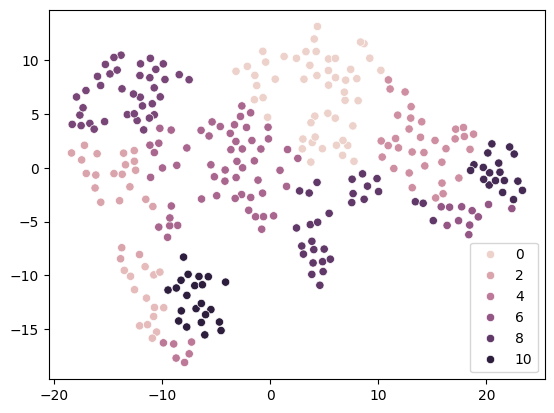

In [9]:
# graficar con el algoritmo t-SNE para visualizar los grupos
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
# grupos predichos
X_t = tsne.fit_transform(X) # entrenar y transformar los datos originales X
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue = pred) # mostrar los datos resultantes en una gráfica

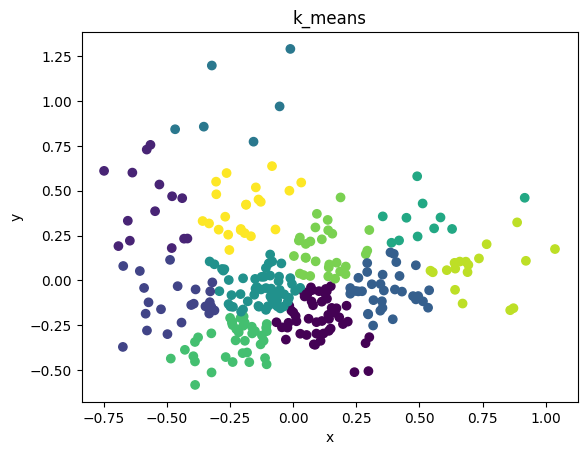

In [10]:
#graficar con PCA
from sklearn.decomposition import PCA
# Visualización en 2D usando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, cmap='viridis')
plt.title('k_means')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
# Obtener el tamaño de cada cluster
unique_labels, counts = np.unique(pred, return_counts=True)
# Imprime el tamaño de cada cluster
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} equipos")

Cluster 0: 50 equipos
Cluster 1: 14 equipos
Cluster 2: 22 equipos
Cluster 3: 33 equipos
Cluster 4: 6 equipos
Cluster 5: 56 equipos
Cluster 6: 11 equipos
Cluster 7: 38 equipos
Cluster 8: 29 equipos
Cluster 9: 18 equipos
Cluster 10: 22 equipos


### GaussianMixture

In [12]:
#paquetes
from sklearn.mixture import GaussianMixture
# Inicializamos y ajustamos el modelo GMM
gmm = GaussianMixture(n_components=11, random_state=42)
y_pred = gmm.fit_predict(X)
y_pred

array([ 4,  4,  4,  4,  8,  8,  5,  1,  3,  3,  4,  3,  2,  3,  0,  6,  0,
        3,  0,  2,  4,  4,  1,  7,  2,  0,  2,  4,  0,  1,  5,  0,  0,  4,
        2,  1,  1,  0,  4,  3,  1,  5,  9,  0,  4,  4,  9,  4,  4, 10,  8,
       10,  3,  2,  4,  3,  8,  8,  9,  4,  4,  1,  5,  5,  8,  1,  0,  4,
        3,  3,  4,  5,  9,  0,  4,  6,  6, 10,  5,  8,  1,  3,  8,  4,  1,
        8,  3,  4,  5, 10,  7,  1,  4,  1,  5,  4,  2,  1,  9,  5,  1,  5,
        0,  8,  2,  7,  9,  5,  4,  8,  3,  4,  4,  8,  3,  9,  1,  1,  0,
        0,  1,  1,  1,  3,  1,  5,  4,  4,  8,  8,  2,  4,  3, 10,  2,  8,
        2,  4,  5,  3,  1,  1,  1,  8,  4,  3,  3,  1,  8,  0,  9,  7,  4,
        7,  7,  3,  1,  9,  2,  5,  5,  2, 10,  0,  2,  3,  4,  1,  4,  1,
        1,  2,  0,  5,  1,  4,  9,  3,  0,  2,  7,  5,  3,  1,  6,  1, 10,
        4,  4,  5,  1,  4,  7,  4,  0,  8,  8,  9,  5,  1,  4,  0,  0,  1,
        1,  5, 10,  4, 10,  5,  5,  4,  6,  1,  1,  4,  4,  8,  3,  5,  2,
        1,  1,  9,  3,  0

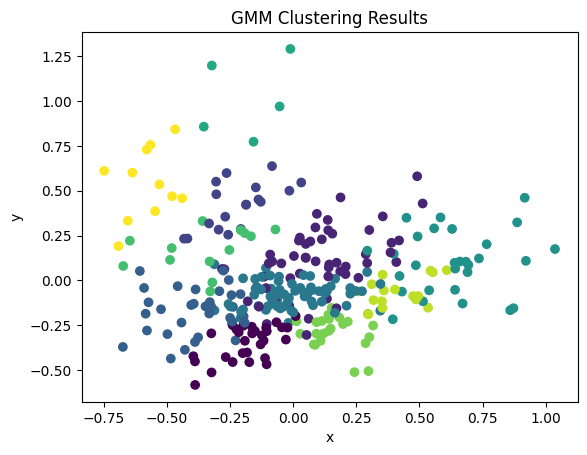

In [13]:
# Visualización en 2D usando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis')
plt.title('GMM Clustering Results')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


<Axes: >

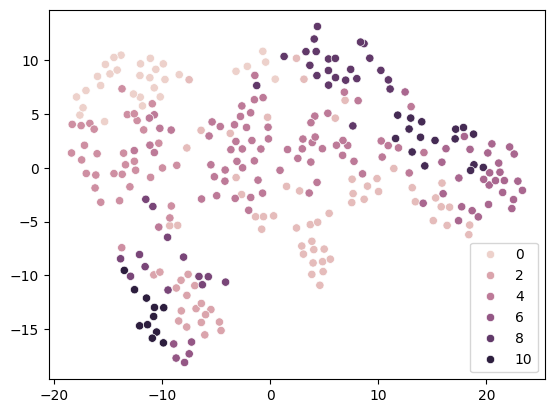

In [14]:
# graficar con el algoritmo t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
# grupos predichos
X_t = tsne.fit_transform(X) # entrenar y transformar los datos originales X
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue = y_pred) # mostrar los datos resultantes en una gráfica

In [15]:
# Obtener el tamaño de cada cluster
unique_labels, counts = np.unique(y_pred, return_counts=True)

# Imprime el tamaño de cada cluster
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} equipos")

Cluster 0: 30 equipos
Cluster 1: 52 equipos
Cluster 2: 18 equipos
Cluster 3: 33 equipos
Cluster 4: 69 equipos
Cluster 5: 29 equipos
Cluster 6: 5 equipos
Cluster 7: 13 equipos
Cluster 8: 23 equipos
Cluster 9: 16 equipos
Cluster 10: 11 equipos


### Agglomerative-clustering

In [16]:
from sklearn.cluster import AgglomerativeClustering
# Inicializamos y ajustamos el modelo de Agglomerative Clustering con 11 clusters
agg_cluster = AgglomerativeClustering(n_clusters=11)
y_labels = agg_cluster.fit_predict(X)
y_labels

array([ 4,  4,  4,  5,  4,  9,  2,  8,  3,  3,  1,  3, 10,  3,  1,  0,  1,
        3,  1,  7,  4,  1,  5,  7, 10,  1,  7,  4,  1,  4,  2,  1,  1,  4,
        7, 10,  8,  1,  4,  1,  5,  2,  2,  1,  5,  5,  2,  1,  5,  0,  9,
        6,  1,  0,  5,  1,  9,  9,  2,  4,  4, 10,  2,  2,  9,  4,  1,  1,
        1,  3,  3,  2,  2,  1,  5,  0,  0,  0,  2,  9, 10,  1,  9,  5, 10,
        9,  1,  5,  2,  0,  7,  5,  5,  4,  2,  5,  7, 10,  2,  2, 10,  8,
        1,  9,  7,  3,  4,  2,  5,  5,  3,  5,  4,  9,  3,  2,  9, 10,  1,
        1,  4,  1,  8,  3,  8,  8,  4,  5,  9,  9,  7,  5,  3,  6,  7,  9,
        7,  4,  2,  3,  5, 10,  4,  9,  4,  1,  6,  3,  9,  9,  4,  6,  3,
        6,  7,  1,  5,  4,  7,  9,  2,  7,  6,  1,  6,  3,  5,  5,  5,  8,
        4,  7,  1,  8,  4,  4,  4,  3,  1,  6,  6,  8,  3, 10,  0,  5,  6,
        5,  5,  2,  5,  5,  3,  1,  1,  9,  9,  4,  8,  5,  5,  1,  1,  5,
        5,  4,  6,  5,  0,  2,  2,  4,  0,  5,  4,  4,  4,  9,  1,  8,  7,
        4,  5,  4,  3,  1

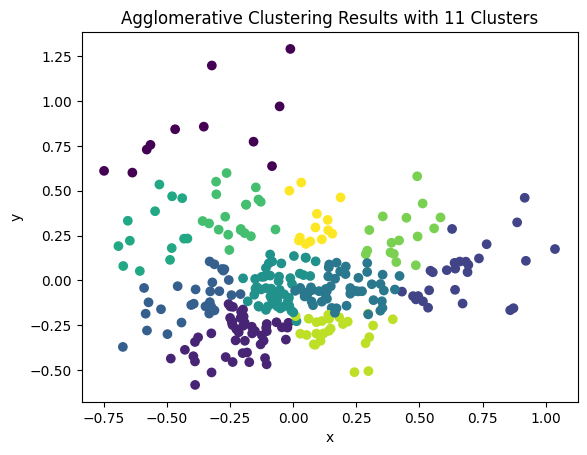

In [17]:
# 2. Visualización en 2D usando PCA (puedes ajustar esto según la dimensionalidad de tus datos)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y_labels, cmap='viridis')
plt.title('Agglomerative Clustering Results with 11 Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<Axes: >

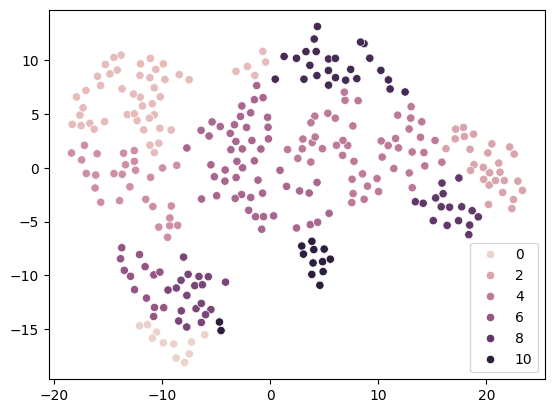

In [18]:
# graficar con el algoritmo t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
# grupos predichos
X_t = tsne.fit_transform(X) # entrenar y transformar los datos originales X
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue = y_labels) # mostrar los datos resultantes en una gráfica

In [19]:
# Obtener el tamaño de cada cluster
unique_labels, counts = np.unique(y_labels, return_counts=True)

# Imprime el tamaño de cada cluster
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} equipos")

Cluster 0: 11 equipos
Cluster 1: 48 equipos
Cluster 2: 27 equipos
Cluster 3: 28 equipos
Cluster 4: 48 equipos
Cluster 5: 51 equipos
Cluster 6: 13 equipos
Cluster 7: 19 equipos
Cluster 8: 16 equipos
Cluster 9: 25 equipos
Cluster 10: 13 equipos


### Spectral clustering

In [20]:
from sklearn.cluster import SpectralClustering
from mpl_toolkits.mplot3d import Axes3D
# Inicializamos y ajustamos el modelo SpectralClustering con 11 clusters
spectral_clustering = SpectralClustering(n_clusters=11, random_state=42)
labels_spectral = spectral_clustering.fit_predict(X)
labels_spectral

array([10,  1,  1, 10,  1,  5,  8,  6,  3,  3, 10,  3,  9, 10, 10,  2,  7,
        3,  7,  9,  1, 10, 10,  9,  9, 10,  9,  1, 10,  1,  8,  7, 10,  1,
        9,  9,  1,  7,  5, 10,  1,  1,  0, 10, 10, 10,  0, 10, 10,  2,  5,
        2,  7,  9, 10, 10,  5, 10,  0,  1,  1,  9,  8,  0,  5,  1,  7, 10,
       10, 10, 10,  0,  0, 10, 10,  4,  9,  2,  0,  5,  9,  7,  5, 10,  9,
        5,  7, 10,  0,  2,  9, 10, 10,  1,  0, 10,  9,  9,  0,  0,  9,  1,
        7,  5,  9, 10,  1,  0, 10, 10,  3, 10,  1,  5,  3,  0, 10,  9,  7,
       10,  1, 10,  1, 10,  1,  6,  1, 10,  5,  5,  9, 10, 10,  2,  9,  5,
        9,  1,  0, 10,  1,  9,  1,  5, 10, 10,  3, 10,  5,  5,  1,  3, 10,
        3,  9,  7, 10,  1,  9,  5,  8,  9,  2,  7,  9, 10, 10,  1, 10,  1,
        1,  9,  7,  1,  1,  1,  1, 10,  7,  9,  3,  6,  3,  9,  4,  1,  2,
       10, 10,  0, 10, 10, 10, 10, 10,  5,  5,  5,  6, 10, 10, 10,  5, 10,
        1,  1,  2, 10,  2,  6,  0,  1,  4,  1,  1,  1,  1,  5,  7,  6,  9,
        1,  1,  1, 10, 10

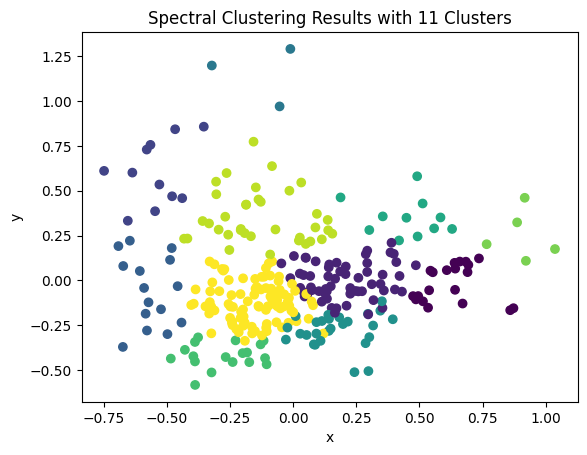

In [21]:
# 2. Visualización en 2D usando PCA (puedes ajustar esto según la dimensionalidad de tus datos)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=labels_spectral, cmap='viridis')
plt.title('Spectral Clustering Results with 11 Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<Axes: >

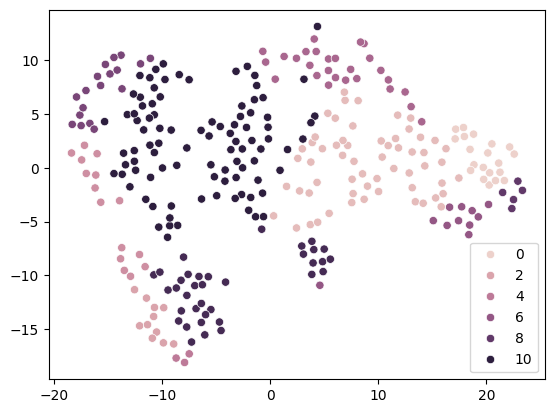

In [22]:
# graficar con el algoritmo t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
# grupos predichos
X_t = tsne.fit_transform(X) # entrenar y transformar los datos originales X
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue = labels_spectral) # mostrar los datos resultantes en una gráfica

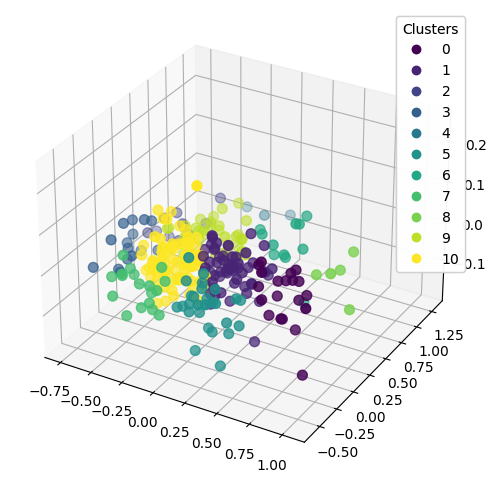

In [23]:
#3D
# Visualización en 3D usando PCA para reducir la dimensionalidad
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

# Crear una figura en 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot en 3D
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_spectral, cmap='viridis', s=50)
# Añadir leyenda
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

# Mostrar el gráfico
plt.show()

In [24]:
# Obtener el tamaño de cada cluster
unique_labels, counts = np.unique(labels_spectral, return_counts=True)

# Imprime el tamaño de cada cluster
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} instancias")

Cluster 0: 20 instancias
Cluster 1: 59 instancias
Cluster 2: 11 instancias
Cluster 3: 15 instancias
Cluster 4: 3 instancias
Cluster 5: 27 instancias
Cluster 6: 11 instancias
Cluster 7: 18 instancias
Cluster 8: 5 instancias
Cluster 9: 36 instancias
Cluster 10: 94 instancias


In [25]:
pip install scikit-learn-extra


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.0 MB/s eta 0:00:00


### Puntaje de Calinski

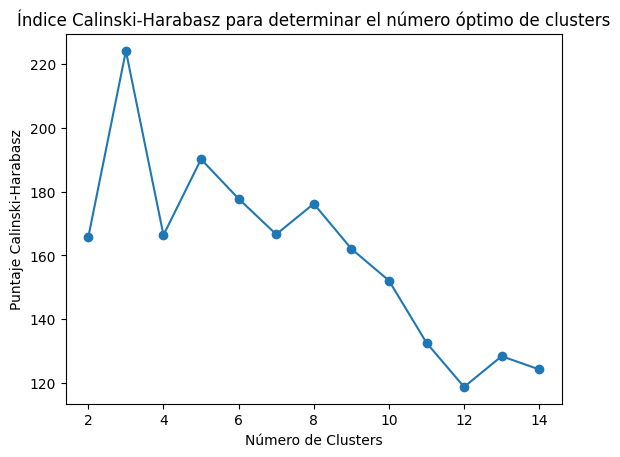

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt

# Rango de los clusters
num_clusters_range = range(2, 15)

# Lista para almacenar los puntajes Calinski-Harabasz
calinski_scores = []

for k in num_clusters_range:
    kmedoids = KMedoids(n_clusters=k,random_state=42)
    kmedoids.fit(X)
    score = calinski_harabasz_score(X, kmedoids.labels_)
    calinski_scores.append(score)
# Graficar los resultados
plt.plot(num_clusters_range, calinski_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntaje Calinski-Harabasz')
plt.title('Índice Calinski-Harabasz para determinar el número óptimo de clusters')
plt.show()

### K-medoids

In [27]:
from sklearn_extra.cluster import KMedoids
# Número de grupos deseados
n = 9
# Inicialización del modelo KMedoids
kmedoids = KMedoids(n_clusters=n, random_state=42)
# Entrenar el modelo
kmedoids.fit(X)
# Obtener las etiquetas de los grupos
labels = kmedoids.labels_
# Obtener los medoides (puntos representativos) de cada grupo
medoids = X[kmedoids.medoid_indices_]

In [29]:
# Obtener el tamaño de cada cluster
unique_labels, counts = np.unique(labels, return_counts=True)

# Imprime el tamaño de cada cluster
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} equipos")

Cluster 0: 35 equipos
Cluster 1: 24 equipos
Cluster 2: 24 equipos
Cluster 3: 40 equipos
Cluster 4: 42 equipos
Cluster 5: 35 equipos
Cluster 6: 31 equipos
Cluster 7: 34 equipos
Cluster 8: 34 equipos


In [30]:
#puntos representativos de mi conjunto de datos (medoides)
medoids

array([[2.9375    , 1.05263158, 0.55921053, 0.20065789, 0.24013158],
       [2.96825397, 1.61111111, 0.28571429, 0.46825397, 0.24603175],
       [2.72983871, 1.39112903, 0.37903226, 0.35887097, 0.26209677],
       [2.55789474, 1.4       , 0.29473684, 0.42631579, 0.27894737],
       [2.33333333, 1.35555556, 0.27777778, 0.45555556, 0.26666667],
       [2.56578947, 1.61842105, 0.22368421, 0.53947368, 0.23684211],
       [3.05882353, 1.94117647, 0.22058824, 0.54411765, 0.23529412],
       [2.71764706, 1.58235294, 0.28823529, 0.45882353, 0.25294118],
       [2.44736842, 1.15413534, 0.41353383, 0.33458647, 0.2518797 ]])

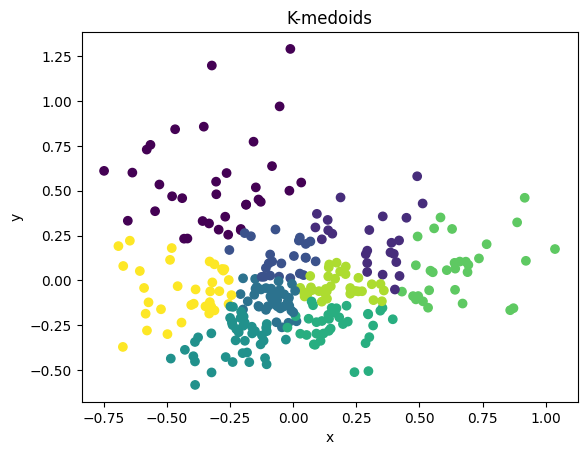

In [31]:
# 2. Visualización en 2D usando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=labels, cmap='viridis')
plt.title('K-medoids')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<Axes: >

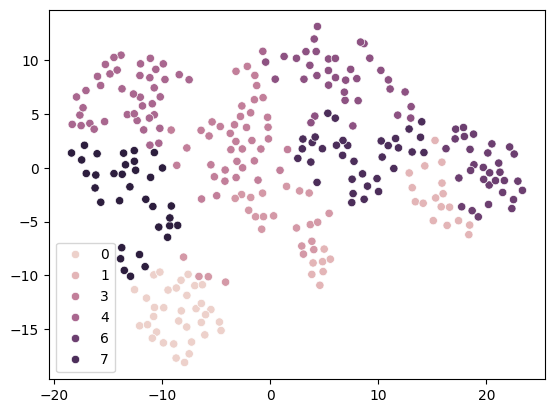

In [32]:
# graficar con el algoritmo t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
# grupos predichos
X_t = tsne.fit_transform(X) # entrenar y transformar los datos originales X
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue = labels) # mostrar los datos resultantes en una gráfica

In [33]:
# Obtener los índices de los medoides
medoid_index = kmedoids.medoid_indices_
medoid_index

array([117,  65, 168, 255, 252, 179, 286, 247,  73, 294, 249,  34, 196,
       270])

<Axes: >

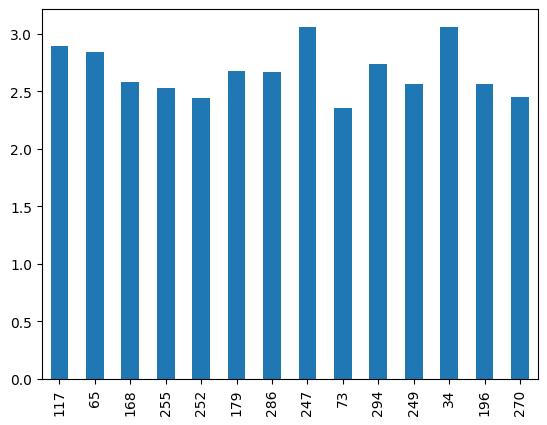

In [34]:
#promedio de goles
df_teams_new["avg_goals"].iloc[medoid_index].plot(kind="bar")

<Axes: >

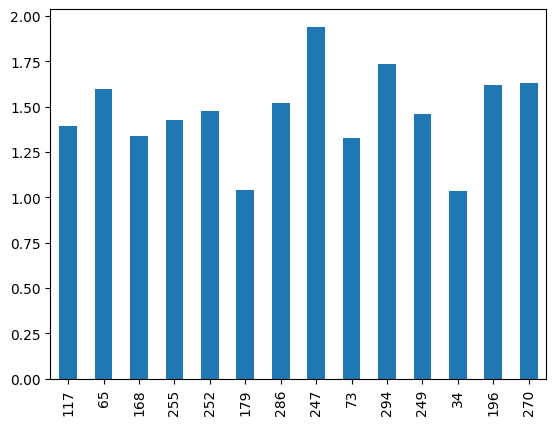

In [35]:
#promedio de goles en contra
df_teams_new["avg_goals_conceded"].iloc[medoid_index].plot(kind="bar")

<Axes: >

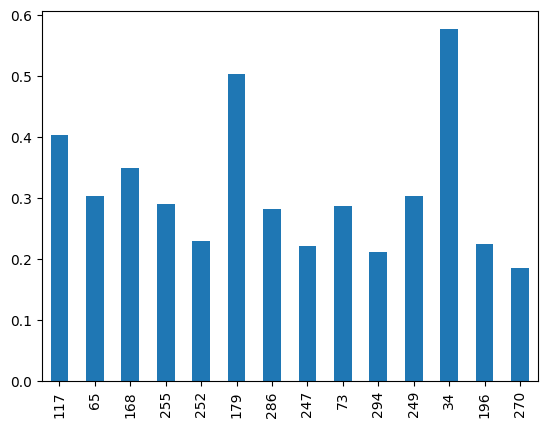

In [36]:
#porcentaje de victorias
df_teams_new["win_percentage"].iloc[medoid_index].plot(kind="bar")

<Axes: >

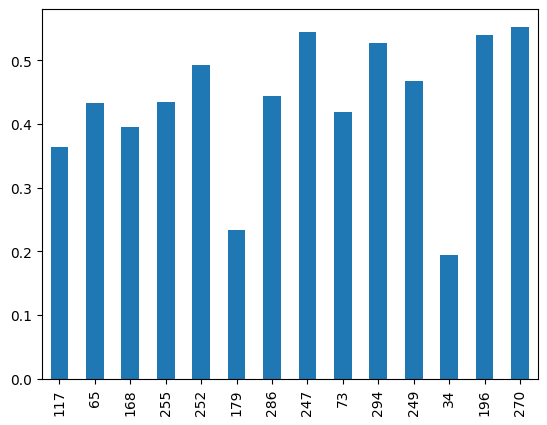

In [37]:
#porcentaje de derrotas
df_teams_new["loss_percentage"].iloc[medoid_index].plot(kind="bar")

<Axes: >

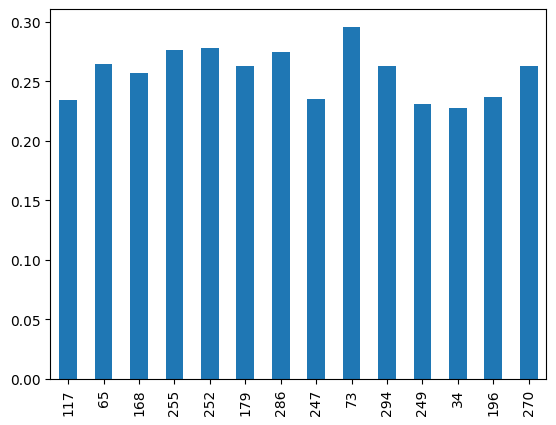

In [38]:
#porcentaje de empate
df_teams_new["draw_percentage"].iloc[medoid_index].plot(kind="bar")

In [39]:
######################## ver tabla de los equipos

### Proponer modificación

**Llenado arbitrario de clusters**

In [40]:
# Función para asignar centroides
def AssignCentroideMaxCluster_A(X_centroids, y_centroids, X, max_cluster_size, p=2):
    Mxnew = len(X)
    ynew = np.zeros(Mxnew, dtype=int)
    cluster_sizes = np.zeros(len(y_centroids), dtype=int)

    for i in range(Mxnew):
        dist = ML.getDistances(X[i], X_centroids, y_centroids, p)
        dist.sort(key=lambda pair: pair[0])

        # Buscar el índice del centroide más cercano que no haya alcanzado su límite
        for _, idx in dist:
            centroid_label=int(idx)
            if cluster_sizes[centroid_label] < max_cluster_size:
                ynew[i] = centroid_label
                cluster_sizes[centroid_label] += 1
                break

    return ynew
#K-means modificado
def k_means_MaxCluster_A(X, k, MAXITE, max_cluster_size, p=2):
    X_centroids, y_centroids = ML.randomCentroids(X, k)

    for i in range(MAXITE):
        y_pred = AssignCentroideMaxCluster_A(X_centroids, y_centroids, X, max_cluster_size, p)
        X_centroids, y_centroids = ML.getCentroids(X, y_pred)

    return y_pred

In [41]:
# Ejemplo de uso:
y_pred = k_means_MaxCluster_A(X, k=11, MAXITE=100, max_cluster_size=28, p=2)

In [42]:
np.bincount(y_pred)

array([26, 28, 27, 28, 28, 28, 28, 22, 28, 28, 28])

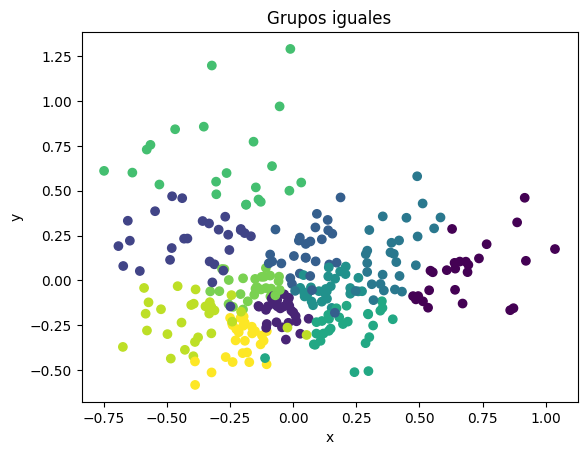

In [43]:
# 2. Visualización en 2D usando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y_pred, cmap='viridis')
plt.title('Grupos iguales')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Llenado no arbitrario**

In [44]:
def AssignCentroideMaxCluster_NA(X_centroids, y_centroids, X, max_cluster_size, p=2):
    Mxnew = len(X)
    ynew = np.zeros(Mxnew, dtype=int)
    cluster_sizes = np.zeros(len(y_centroids), dtype=int)

    # Inicializar lista de puntos sobrantes para cada centroide
    points_overflow = [[] for _ in range(len(y_centroids))]

    # Asignar cada punto al centroide más cercano
    for i in range(Mxnew):
        dist_to_centroids = [ML.disMinkowski(X[i], c, p) for c in X_centroids]
        centroid_label = np.argmin(dist_to_centroids)
        ynew[i] = y_centroids[centroid_label]
        cluster_sizes[centroid_label] += 1

        # Si el tamaño del cluster excede el límite, agregar punto a lista de sobrantes
        if cluster_sizes[centroid_label] > max_cluster_size:
            points_overflow[centroid_label].append(i)

    # Reasignar puntos sobrantes a otros centroides mientras se cumple el límite de tamaño
    for centroid_label, overflow in enumerate(points_overflow):
        while overflow:
            # Ordenar los puntos sobrantes por distancia al centroide actual
            overflow.sort(key=lambda x: ML.disMinkowski(X[x], X_centroids[centroid_label], p))

            # Reasignar punto sobrante al centroide más cercano disponible
            for i in overflow:
                dist_to_centroids = [ML.disMinkowski(X[i], c, p) for c in X_centroids]
                sorted_centroids = np.argsort(dist_to_centroids)

                for idx in sorted_centroids:
                    if cluster_sizes[idx] < max_cluster_size:
                        ynew[i] = y_centroids[idx]
                        cluster_sizes[idx] += 1
                        overflow.remove(i)
                        break

    return ynew

def k_means_MaxCluster_NA(X, k, MAXITE, max_cluster_size, p=2):
    X_centroids, y_centroids = ML.randomCentroids(X, k)

    for i in range(MAXITE):
        y_pred = AssignCentroideMaxCluster_NA(X_centroids, y_centroids, X, max_cluster_size, p)
        X_centroids, y_centroids = ML.getCentroids(X, y_pred)

    return y_pred


In [45]:
y_pred2= k_means_MaxCluster_NA(X, 11, 100, 28)

In [46]:
np.bincount(y_pred2)

array([28, 28, 28, 28, 28, 28, 24, 25, 26, 28, 28])

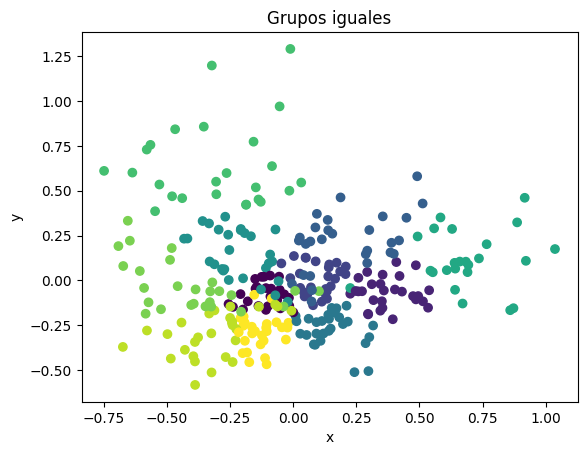

In [47]:
# 2. Visualización en 2D usando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y_pred2, cmap='viridis')
plt.title('Grupos iguales')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Análisis de los resultados

In [48]:
C,y_c=ML.getCentroids(X,y_pred2)
C

array([[2.55779288, 1.38500314, 0.31702002, 0.40511879, 0.27786119],
       [2.79689682, 1.77054276, 0.2185152 , 0.53320122, 0.24828359],
       [2.72419755, 1.52645241, 0.31257737, 0.43707053, 0.2503521 ],
       [2.96341473, 1.54891353, 0.34442989, 0.40353968, 0.25203042],
       [2.52455547, 1.64105888, 0.19536853, 0.5480913 , 0.25654017],
       [2.69758166, 1.22734502, 0.42701926, 0.31944955, 0.25353119],
       [3.09153449, 1.97761028, 0.22225165, 0.55914925, 0.2185991 ],
       [3.07525369, 0.99356136, 0.61599836, 0.18002135, 0.20398029],
       [2.46070144, 1.1323699 , 0.41242713, 0.31563288, 0.27194   ],
       [2.27693304, 1.28056255, 0.29218911, 0.42680481, 0.28100607],
       [2.37798686, 1.41602323, 0.24722542, 0.47366485, 0.27910973]])

In [49]:
def getCentroidIndices(X_data, y_data):
    y_unique = np.unique(y_data)  # Vector con valores de y_data sin repetir
    centroid_indices = []

    for label in y_unique:
        indices = np.where(y_data == label)[0]  # Obtenemos los índices de los puntos con la etiqueta actual
        centroid_indices.append(indices[0])  # Tomamos el primer índice como representante del centroide

    return centroid_indices

In [50]:
i=getCentroidIndices(X,y_pred2)
i

[44, 29, 0, 7, 4, 3, 6, 12, 9, 8, 10]

In [51]:
# Función para encontrar el índice de la fila más cercana a cada centroide
def encontrar_indices_mas_cercanos(centroides, df):
    indices_centroides_cercanos = []
    for centroide in centroides:
        distancias = np.linalg.norm(df.values - centroide, axis=1)
        indice_mas_cercano = np.argmin(distancias)
        indices_centroides_cercanos.append(indice_mas_cercano)
    return indices_centroides_cercanos


In [52]:
# Encontrar los índices de las filas más cercanas a cada centroide
i = encontrar_indices_mas_cercanos(C, df_teams_new)
i

[108, 293, 296, 183, 50, 154, 99, 34, 165, 288, 201]

<Axes: >

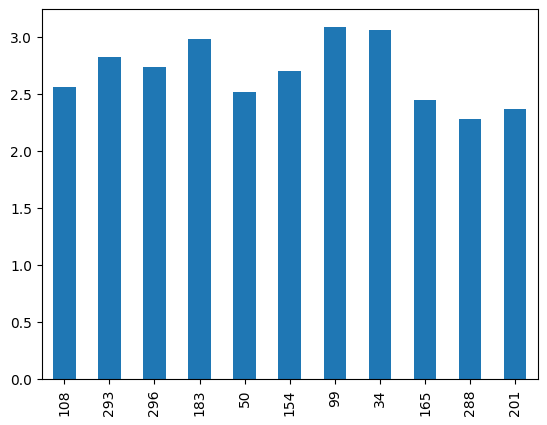

In [53]:
#pormedio de goles
df_teams_new["avg_goals"].iloc[i].plot(kind="bar")

<Axes: >

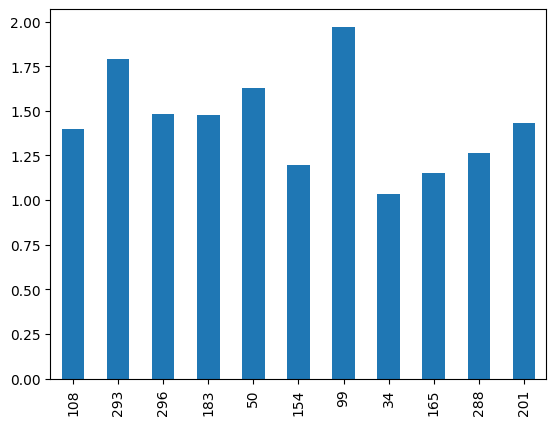

In [54]:
#promedio goles en contra
df_teams_new["avg_goals_conceded"].iloc[i].plot(kind="bar")

<Axes: >

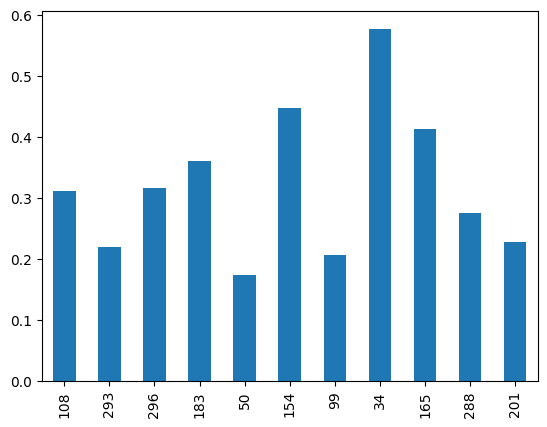

In [55]:
#porcentaje de victorias
df_teams_new["win_percentage"].iloc[i].plot(kind="bar")

<Axes: >

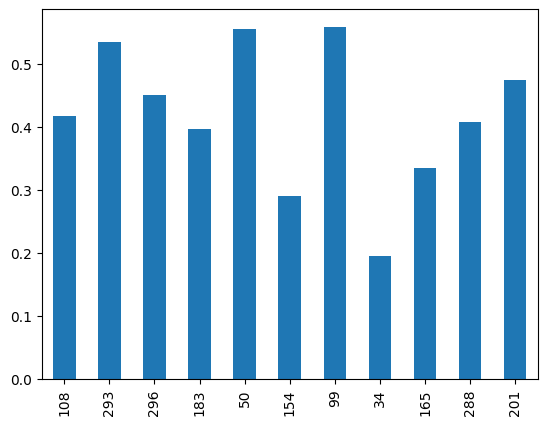

In [56]:
#porcentaje de derrotas
df_teams_new["loss_percentage"].iloc[i].plot(kind="bar")

In [58]:
#Información  para obtener las ligas
query = """
    SELECT DISTINCT Team.team_api_id, League.name as league_name
    FROM Team
    JOIN Match ON Team.team_api_id = Match.home_team_api_id OR Team.team_api_id = Match.away_team_api_id
    JOIN League ON Match.league_id = League.id
"""
# Leer la información de la base de datos
df_labels = pd.read_sql_query(query, conn)
# Mostrar las primeras filas del DataFrame con información de etiquetas
df_labels.head()

,team_api_id,league_name
0,9987,Belgium Jupiler League
1,9993,Belgium Jupiler League
2,9994,Belgium Jupiler League
3,10000,Belgium Jupiler League
4,8635,Belgium Jupiler League


In [59]:
# Mapeo de nombres de liga a etiquetas numéricas
league_mapping = {name: idx for idx, name in enumerate(df_labels['league_name'].unique())}
# Crear una nueva columna 'league_label' con etiquetas numéricas
df_labels['league_label'] = df_labels['league_name'].map(league_mapping)
# Obtener un vector de etiquetas no ordenadas
labels = df_labels['league_label'].values
# Mostrar las primeras filas del DataFrame con información de etiquetas
df_labels.head(10)

,team_api_id,league_name,league_label
0,9987,Belgium Jupiler League,0
1,9993,Belgium Jupiler League,0
2,9994,Belgium Jupiler League,0
3,10000,Belgium Jupiler League,0
4,8635,Belgium Jupiler League,0
5,9984,Belgium Jupiler League,0
6,9991,Belgium Jupiler League,0
7,9998,Belgium Jupiler League,0
8,7947,Belgium Jupiler League,0
9,9985,Belgium Jupiler League,0


In [60]:
#Mapeado de etiquetas al mismo orden del data frame df_teams
n=len(df_labels["team_api_id"])
etiquetas=np.zeros(n)
for i in range (n):
  for j in range (n):
    if (df_teams["team_api_id"][i]==df_labels["team_api_id"][j]):
      etiquetas[i]=df_labels["league_label"][j]

In [ ]:
#diccionario de las ligas
mapeo_ligas = {0: 'Belgium Jupiler League', 1: 'England Premier League', 2: 'France Ligue 1',
               3: "Germany 1. Bundesliga",4: "Italy Serie A",5: "Netherlands Eredivisie", 6:"Poland Ekstraklasa", 7:"Portugal Liga ZON Sagres",
               8:"Scotland Premier League",9:"Spain LIGA BBVA", 10: "Switzerland Super League"}
# Decodificación de números de etiqueta a nombres de ligas del vector de etiquetas original
nombres_ligas = [mapeo_ligas[num] for num in etiquetas]
nombres_ligas

In [ ]:
#ligas para las etiquetas predichas
nombres_ligas_new = [mapeo_ligas[num] for num in y_pred2]
nombres_ligas_new

In [ ]:
#Mostrar predicciones
df_teams['liga_predicha'] = nombres_ligas_new
df_teams["liga_predicha"].value_counts()

In [ ]:
df_teams.to_markdown()

|     | team_long_name               |   team_api_id |   avg_goals |   avg_goals_conceded |   goal_difference_avg |   total_points_avg |   win_percentage |   loss_percentage |   draw_percentage | liga_predicha            |
|----:|:-----------------------------|--------------:|------------:|---------------------:|----------------------:|-------------------:|-----------------:|------------------:|------------------:|:-------------------------|
|   0 | 1. FC Kaiserslautern         |          8350 |     2.60294 |             1.54412  |           -0.485294   |           1.01471  |        0.25      |         0.485294  |          0.264706 | France Ligue 1           |
|   1 | 1. FC Köln                   |          8722 |     2.63235 |             1.52451  |           -0.416667   |           1.14706  |        0.294118  |         0.441176  |          0.264706 | France Ligue 1           |
|   2 | 1. FC Nürnberg               |          8165 |     2.71765 |             1.58235  |           -0.447059   |           1.11765  |        0.288235  |         0.458824  |          0.252941 | France Ligue 1           |
|   3 | 1. FSV Mainz 05              |          9905 |     2.68487 |             1.34034  |            0.00420168 |           1.38235  |        0.369748  |         0.357143  |          0.273109 | Netherlands Eredivisie   |
|   4 | AC Ajaccio                   |          8576 |     2.63158 |             1.61404  |           -0.596491   |           0.929825 |        0.192982  |         0.45614   |          0.350877 | Italy Serie A            |
|   5 | AC Arles-Avignon             |        108893 |     2.39474 |             1.84211  |           -1.28947    |           0.526316 |        0.0789474 |         0.631579  |          0.289474 | Italy Serie A            |
|   6 | AC Bellinzona                |          6493 |     3.2037  |             2.01852  |           -0.833333   |           0.925926 |        0.231481  |         0.537037  |          0.231481 | Poland Ekstraklasa       |
|   7 | ADO Den Haag                 |         10217 |     3.06618 |             1.72059  |           -0.375      |           1.14338  |        0.290441  |         0.4375    |          0.272059 | Germany 1. Bundesliga    |
|   8 | AJ Auxerre                   |          8583 |     2.17105 |             1.06579  |            0.0394737  |           1.375    |        0.348684  |         0.322368  |          0.328947 | Spain LIGA BBVA          |
|   9 | AS Monaco                    |          9829 |     2.29825 |             1.03947  |            0.219298   |           1.57895  |        0.416667  |         0.254386  |          0.328947 | Scotland Premier League  |
|  10 | AS Nancy-Lorraine            |          8481 |     2.40526 |             1.33684  |           -0.268421   |           1.16316  |        0.294737  |         0.426316  |          0.278947 | Switzerland Super League |
|  11 | AS Saint-Étienne             |          9853 |     2.29276 |             1.07237  |            0.148026   |           1.46382  |        0.398026  |         0.332237  |          0.269737 | Scotland Premier League  |
|  12 | AZ                           |         10229 |     3.08824 |             1.27941  |            0.529412   |           1.73897  |        0.514706  |         0.290441  |          0.194853 | Portugal Liga ZON Sagres |
|  13 | Aberdeen                     |          8485 |     2.375   |             1.17434  |            0.0263158  |           1.43092  |        0.394737  |         0.358553  |          0.246711 | Scotland Premier League  |
|  14 | Académica de Coimbra         |         10215 |     2.3629  |             1.39516  |           -0.427419   |           1.00806  |        0.225806  |         0.443548  |          0.330645 | Switzerland Super League |
|  15 | Ajax                         |          8593 |     3.24632 |             0.867647 |            1.51103    |           2.21324  |        0.665441  |         0.117647  |          0.216912 | Portugal Liga ZON Sagres |
|  16 | Amadora                      |         10213 |     2.13333 |             1.26667  |           -0.4        |           1.13333  |        0.266667  |         0.4       |          0.333333 | Spain LIGA BBVA          |
|  17 | Angers SCO                   |          8121 |     2.05263 |             1        |            0.0526316  |           1.31579  |        0.342105  |         0.368421  |          0.289474 | Spain LIGA BBVA          |
|  18 | Arka Gdynia                  |          8322 |     2.2     |             1.34444  |           -0.488889   |           0.955556 |        0.222222  |         0.488889  |          0.288889 | Spain LIGA BBVA          |
|  19 | Arsenal                      |          9825 |     2.9375  |             1.05263  |            0.832237   |           1.91776  |        0.559211  |         0.200658  |          0.240132 | Portugal Liga ZON Sagres |
|  20 | Aston Villa                  |         10252 |     2.62171 |             1.51974  |           -0.417763   |           1.13816  |        0.282895  |         0.427632  |          0.289474 | France Ligue 1           |
|  21 | Atalanta                     |          8524 |     2.41445 |             1.3384   |           -0.262357   |           1.1635   |        0.30038   |         0.437262  |          0.262357 | Switzerland Super League |
|  22 | Athletic Club de Bilbao      |          8315 |     2.72039 |             1.35526  |            0.00986842 |           1.4375   |        0.401316  |         0.365132  |          0.233553 | Netherlands Eredivisie   |
|  23 | Atlético Madrid              |          9906 |     2.77961 |             1.05592  |            0.667763   |           1.84211  |        0.549342  |         0.256579  |          0.194079 | Netherlands Eredivisie   |
|  24 | BSC Young Boys               |         10192 |     3.15385 |             1.3042   |            0.545455   |           1.73077  |        0.496503  |         0.262238  |          0.241259 | Portugal Liga ZON Sagres |
|  25 | Bari                         |          9976 |     2.38158 |             1.38158  |           -0.381579   |           0.973684 |        0.236842  |         0.5       |          0.263158 | Switzerland Super League |
|  26 | Bayer 04 Leverkusen          |          8178 |     2.98529 |             1.20956  |            0.566176   |           1.75368  |        0.503676  |         0.253676  |          0.242647 | Portugal Liga ZON Sagres |
|  27 | Beerschot AC                 |          9993 |     2.70395 |             1.55921  |           -0.414474   |           1.06579  |        0.263158  |         0.460526  |          0.276316 | France Ligue 1           |
|  28 | Birmingham City              |          8658 |     2.36842 |             1.38158  |           -0.394737   |           1.17105  |        0.276316  |         0.381579  |          0.342105 | Switzerland Super League |
|  29 | Blackburn Rovers             |          8655 |     2.80921 |             1.65789  |           -0.506579   |           1.08553  |        0.276316  |         0.467105  |          0.256579 | England Premier League   |
|  30 | Blackpool                    |          8483 |     3.5     |             2.05263  |           -0.605263   |           1.02632  |        0.263158  |         0.5       |          0.236842 | Poland Ekstraklasa       |
|  31 | Boavista FC                  |          8613 |     2.08824 |             1.33824  |           -0.588235   |           0.985294 |        0.25      |         0.514706  |          0.235294 | Spain LIGA BBVA          |
|  32 | Bologna                      |          9857 |     2.38783 |             1.38783  |           -0.387833   |           1.07605  |        0.258555  |         0.441065  |          0.30038  | Switzerland Super League |
|  33 | Bolton Wanderers             |          8559 |     2.85526 |             1.66447  |           -0.473684   |           1.06579  |        0.282895  |         0.5       |          0.217105 | England Premier League   |
|  34 | Borussia Dortmund            |          9789 |     3.0625  |             1.03676  |            0.988971   |           1.95956  |        0.577206  |         0.194853  |          0.227941 | Portugal Liga ZON Sagres |
|  35 | Borussia Mönchengladbach     |          9788 |     2.875   |             1.39338  |            0.0882353  |           1.43015  |        0.400735  |         0.371324  |          0.227941 | Germany 1. Bundesliga    |
|  36 | Bournemouth                  |          8678 |     2.94737 |             1.76316  |           -0.578947   |           1.10526  |        0.289474  |         0.473684  |          0.236842 | England Premier League   |
|  37 | Brescia                      |          9858 |     2.26316 |             1.36842  |           -0.473684   |           0.842105 |        0.184211  |         0.526316  |          0.289474 | Switzerland Super League |
|  38 | Burnley                      |          8191 |     2.69737 |             1.77632  |           -0.855263   |           0.828947 |        0.197368  |         0.565789  |          0.236842 | England Premier League   |
|  39 | CA Osasuna                   |          8371 |     2.38596 |             1.36842  |           -0.350877   |           1.16228  |        0.29386   |         0.425439  |          0.280702 | Switzerland Super League |
|  40 | CD Nacional                  |         10214 |     2.72984 |             1.39113  |           -0.0524194  |           1.39919  |        0.379032  |         0.358871  |          0.262097 | France Ligue 1           |
|  41 | CD Numancia                  |          8388 |     2.81579 |             1.81579  |           -0.815789   |           0.921053 |        0.263158  |         0.605263  |          0.131579 | England Premier League   |
|  42 | CD Tenerife                  |          9867 |     3       |             1.94737  |           -0.894737   |           0.947368 |        0.236842  |         0.526316  |          0.236842 | Poland Ekstraklasa       |
|  43 | CF Os Belenenses             |          9807 |     2.39241 |             1.4557   |           -0.518987   |           1.03797  |        0.234177  |         0.43038   |          0.335443 | Switzerland Super League |
|  44 | CS Marítimo                  |         10212 |     2.66935 |             1.39516  |           -0.120968   |           1.29435  |        0.342742  |         0.391129  |          0.266129 | Belgium Jupiler League   |
|  45 | Cagliari                     |          8529 |     2.60227 |             1.43182  |           -0.261364   |           1.14394  |        0.287879  |         0.431818  |          0.280303 | Belgium Jupiler League   |
|  46 | Cardiff City                 |          8344 |     2.78947 |             1.94737  |           -1.10526    |           0.789474 |        0.184211  |         0.578947  |          0.236842 | England Premier League   |
|  47 | Carpi                        |        208931 |     2.47368 |             1.5      |           -0.526316   |           1        |        0.236842  |         0.473684  |          0.289474 | Switzerland Super League |
|  48 | Catania                      |          8530 |     2.49554 |             1.375    |           -0.254464   |           1.17857  |        0.299107  |         0.419643  |          0.28125  | Belgium Jupiler League   |
|  49 | Celtic                       |          9925 |     3.01974 |             0.733553 |            1.55263    |           2.31579  |        0.717105  |         0.118421  |          0.164474 | Portugal Liga ZON Sagres |
|  50 | Cesena                       |          9880 |     2.51818 |             1.62727  |           -0.736364   |           0.790909 |        0.172727  |         0.554545  |          0.272727 | Italy Serie A            |
|  51 | Chelsea                      |          8455 |     2.85855 |             0.940789 |            0.976974   |           1.96711  |        0.578947  |         0.190789  |          0.230263 | Portugal Liga ZON Sagres |
|  52 | Chievo Verona                |          8533 |     2.15182 |             1.21122  |           -0.270627   |           1.14851  |        0.287129  |         0.425743  |          0.287129 | Spain LIGA BBVA          |
|  53 | Club Brugge KV               |          8342 |     3.16981 |             1.18396  |            0.801887   |           1.92925  |        0.580189  |         0.231132  |          0.188679 | Portugal Liga ZON Sagres |
|  54 | Cracovia                     |          2186 |     2.51429 |             1.39524  |           -0.27619    |           1.12381  |        0.290476  |         0.457143  |          0.252381 | Belgium Jupiler League   |
|  55 | Crystal Palace               |          9826 |     2.35965 |             1.31579  |           -0.27193    |           1.18421  |        0.324561  |         0.464912  |          0.210526 | Spain LIGA BBVA          |
|  56 | Córdoba CF                   |          7869 |     2.36842 |             1.78947  |           -1.21053    |           0.526316 |        0.0789474 |         0.631579  |          0.289474 | Italy Serie A            |
|  57 | DSC Arminia Bielefeld        |          9912 |     2.5     |             1.64706  |           -0.794118   |           0.823529 |        0.117647  |         0.411765  |          0.470588 | Italy Serie A            |
|  58 | De Graafschap                |          8526 |     2.82353 |             1.86765  |           -0.911765   |           0.845588 |        0.198529  |         0.551471  |          0.25     | England Premier League   |
|  59 | Dijon FCO                    |          9836 |     2.65789 |             1.65789  |           -0.657895   |           0.947368 |        0.236842  |         0.526316  |          0.236842 | Italy Serie A            |
|  60 | Dundee FC                    |          8284 |     2.69298 |             1.57895  |           -0.464912   |           1.07895  |        0.254386  |         0.429825  |          0.315789 | France Ligue 1           |
|  61 | Dundee United                |          9938 |     2.87171 |             1.43092  |            0.00986842 |           1.40789  |        0.378289  |         0.348684  |          0.273026 | Germany 1. Bundesliga    |
|  62 | Dunfermline Athletic         |          8457 |     3.21053 |             2.15789  |           -1.10526    |           0.657895 |        0.131579  |         0.605263  |          0.263158 | Poland Ekstraklasa       |
|  63 | ES Troyes AC                 |         10242 |     2.82895 |             1.89474  |           -0.960526   |           0.723684 |        0.144737  |         0.565789  |          0.289474 | England Premier League   |
|  64 | Eintracht Braunschweig       |          9776 |     2.61765 |             1.76471  |           -0.911765   |           0.735294 |        0.176471  |         0.617647  |          0.205882 | Italy Serie A            |
|  65 | Eintracht Frankfurt          |          9810 |     2.84034 |             1.59664  |           -0.352941   |           1.17227  |        0.302521  |         0.432773  |          0.264706 | France Ligue 1           |
|  66 | Elche CF                     |         10268 |     2.32895 |             1.47368  |           -0.618421   |           1.06579  |        0.263158  |         0.460526  |          0.276316 | Switzerland Super League |
|  67 | Empoli                       |          8534 |     2.46053 |             1.32895  |           -0.197368   |           1.15789  |        0.263158  |         0.368421  |          0.368421 | Belgium Jupiler League   |
|  68 | En Avant de Guingamp         |          9747 |     2.41228 |             1.34211  |           -0.27193    |           1.18421  |        0.324561  |         0.464912  |          0.210526 | Switzerland Super League |
|  69 | Estoril Praia                |          7842 |     2.55469 |             1.25     |            0.0546875  |           1.45312  |        0.390625  |         0.328125  |          0.28125  | Netherlands Eredivisie   |
|  70 | Everton                      |          8668 |     2.61184 |             1.16776  |            0.276316   |           1.52303  |        0.398026  |         0.273026  |          0.328947 | Netherlands Eredivisie   |
|  71 | Excelsior                    |         10218 |     3.08088 |             1.94853  |           -0.816176   |           0.852941 |        0.198529  |         0.544118  |          0.257353 | Poland Ekstraklasa       |
|  72 | FC Aarau                     |          9930 |     2.96528 |             1.90278  |           -0.840278   |           0.965278 |        0.243056  |         0.520833  |          0.236111 | Poland Ekstraklasa       |
|  73 | FC Arouca                    |        158085 |     2.35714 |             1.32653  |           -0.295918   |           1.15306  |        0.285714  |         0.418367  |          0.295918 | Spain LIGA BBVA          |
|  74 | FC Augsburg                  |          8406 |     2.60588 |             1.42353  |           -0.241176   |           1.23529  |        0.323529  |         0.411765  |          0.264706 | Belgium Jupiler League   |
|  75 | FC Barcelona                 |          8634 |     3.55592 |             0.763158 |            2.02961    |           2.45066  |        0.769737  |         0.0888158 |          0.141447 | Portugal Liga ZON Sagres |
|  76 | FC Basel                     |          9931 |     3.25175 |             1.08741  |            1.07692    |           2.11189  |        0.629371  |         0.146853  |          0.223776 | Portugal Liga ZON Sagres |
|  77 | FC Bayern Munich             |          9823 |     3.17647 |             0.775735 |            1.625      |           2.29044  |        0.709559  |         0.128676  |          0.161765 | Portugal Liga ZON Sagres |
|  78 | FC Dordrecht                 |          6631 |     2.94118 |             2.23529  |           -1.52941    |           0.588235 |        0.117647  |         0.647059  |          0.235294 | Poland Ekstraklasa       |
|  79 | FC Energie Cottbus           |          8398 |     2.55882 |             1.67647  |           -0.794118   |           0.882353 |        0.235294  |         0.588235  |          0.176471 | Italy Serie A            |
|  80 | FC Groningen                 |          8674 |     2.91544 |             1.48162  |           -0.0477941  |           1.43015  |        0.400735  |         0.371324  |          0.227941 | Germany 1. Bundesliga    |
|  81 | FC Ingolstadt 04             |          8234 |     2.20588 |             1.23529  |           -0.264706   |           1.17647  |        0.294118  |         0.411765  |          0.294118 | Spain LIGA BBVA          |
|  82 | FC Lausanne-Sports           |          7730 |     2.66038 |             1.72642  |           -0.792453   |           0.820755 |        0.216981  |         0.613208  |          0.169811 | England Premier League   |
|  83 | FC Lorient                   |          8689 |     2.57566 |             1.33224  |           -0.0888158  |           1.25658  |        0.319079  |         0.381579  |          0.299342 | Belgium Jupiler League   |
|  84 | FC Luzern                    |         10199 |     2.8986  |             1.42657  |            0.0454545  |           1.36014  |        0.367133  |         0.374126  |          0.258741 | Germany 1. Bundesliga    |
|  85 | FC Metz                      |          8550 |     2.42105 |             1.60526  |           -0.789474   |           0.789474 |        0.184211  |         0.578947  |          0.236842 | Italy Serie A            |
|  86 | FC Nantes                    |          9830 |     2.07895 |             1.19079  |           -0.302632   |           1.17763  |        0.296053  |         0.414474  |          0.289474 | Spain LIGA BBVA          |
|  87 | FC Paços de Ferreira         |          6403 |     2.58468 |             1.40726  |           -0.229839   |           1.27016  |        0.322581  |         0.375     |          0.302419 | Belgium Jupiler League   |
|  88 | FC Penafiel                  |          6547 |     2.88235 |             2.02941  |           -1.17647    |           0.647059 |        0.147059  |         0.647059  |          0.205882 | Poland Ekstraklasa       |
|  89 | FC Porto                     |          9773 |     2.83065 |             0.649194 |            1.53226    |           2.38306  |        0.737903  |         0.0927419 |          0.169355 | Portugal Liga ZON Sagres |
|  90 | FC Schalke 04                |         10189 |     2.80147 |             1.23529  |            0.330882   |           1.61029  |        0.466912  |         0.323529  |          0.209559 | Netherlands Eredivisie   |
|  91 | FC Sion                      |         10179 |     2.63986 |             1.34266  |           -0.0454545  |           1.33217  |        0.363636  |         0.395105  |          0.241259 | Belgium Jupiler League   |
|  92 | FC Sochaux-Montbéliard       |          9874 |     2.48684 |             1.40789  |           -0.328947   |           1.15789  |        0.302632  |         0.447368  |          0.25     | Belgium Jupiler League   |
|  93 | FC St. Gallen                |         10190 |     2.83796 |             1.56019  |           -0.282407   |           1.23148  |        0.333333  |         0.435185  |          0.231481 | France Ligue 1           |
|  94 | FC St. Pauli                 |          8152 |     3.02941 |             2        |           -0.970588   |           0.852941 |        0.235294  |         0.617647  |          0.147059 | Poland Ekstraklasa       |
|  95 | FC Thun                      |         10191 |     2.6215  |             1.31776  |           -0.0140187  |           1.31308  |        0.331776  |         0.350467  |          0.317757 | Belgium Jupiler League   |
|  96 | FC Twente                    |          8611 |     3.04412 |             1.17279  |            0.698529   |           1.84926  |        0.529412  |         0.209559  |          0.261029 | Portugal Liga ZON Sagres |
|  97 | FC Utrecht                   |          9908 |     2.97794 |             1.47794  |            0.0220588  |           1.41544  |        0.386029  |         0.356618  |          0.257353 | Germany 1. Bundesliga    |
|  98 | FC Vaduz                     |          9824 |     2.81481 |             1.88889  |           -0.962963   |           0.824074 |        0.175926  |         0.527778  |          0.296296 | England Premier League   |
|  99 | FC Volendam                  |          6601 |     3.08824 |             1.97059  |           -0.852941   |           0.852941 |        0.205882  |         0.558824  |          0.235294 | Poland Ekstraklasa       |
| 100 | FC Zürich                    |         10243 |     3.03846 |             1.4021   |            0.234266   |           1.5      |        0.41958   |         0.339161  |          0.241259 | Germany 1. Bundesliga    |
| 101 | FCV Dender EH                |          7947 |     3       |             1.70588  |           -0.411765   |           1.02941  |        0.264706  |         0.5       |          0.235294 | Germany 1. Bundesliga    |
| 102 | Falkirk                      |          8596 |     2.32895 |             1.43421  |           -0.539474   |           0.907895 |        0.197368  |         0.486842  |          0.315789 | Switzerland Super League |
| 103 | Feirense                     |          4064 |     2.53333 |             1.63333  |           -0.733333   |           0.8      |        0.166667  |         0.533333  |          0.3      | Italy Serie A            |
| 104 | Feyenoord                    |         10235 |     2.99265 |             1.19485  |            0.602941   |           1.76471  |        0.511029  |         0.257353  |          0.231618 | Portugal Liga ZON Sagres |
| 105 | Fiorentina                   |          8535 |     2.61    |             1.14333  |            0.323333   |           1.57     |        0.44      |         0.31      |          0.25     | Netherlands Eredivisie   |
| 106 | Fortuna Düsseldorf           |          8194 |     2.82353 |             1.67647  |           -0.529412   |           0.882353 |        0.205882  |         0.529412  |          0.264706 | England Premier League   |
| 107 | Frosinone                    |          9891 |     2.92105 |             2        |           -1.07895    |           0.815789 |        0.210526  |         0.605263  |          0.184211 | Poland Ekstraklasa       |
| 108 | Fulham                       |          9879 |     2.5614  |             1.39912  |           -0.236842   |           1.20614  |        0.311404  |         0.416667  |          0.27193  | Belgium Jupiler League   |
| 109 | GFC Ajaccio                  |          6391 |     2.5     |             1.52632  |           -0.552632   |           0.973684 |        0.210526  |         0.447368  |          0.342105 | Italy Serie A            |
| 110 | GKS Bełchatów                |          8569 |     2.18889 |             1.13333  |           -0.0777778  |           1.30556  |        0.344444  |         0.383333  |          0.272222 | Spain LIGA BBVA          |
| 111 | Genoa                        |         10233 |     2.65894 |             1.36093  |           -0.0629139  |           1.31457  |        0.350993  |         0.387417  |          0.261589 | Belgium Jupiler League   |
| 112 | Getafe CF                    |          8305 |     2.63816 |             1.50329  |           -0.368421   |           1.16118  |        0.309211  |         0.457237  |          0.233553 | France Ligue 1           |
| 113 | Gil Vicente FC               |          9764 |     2.44355 |             1.55645  |           -0.669355   |           0.91129  |        0.209677  |         0.508065  |          0.282258 | Italy Serie A            |
| 114 | Girondins de Bordeaux        |          9827 |     2.43092 |             1.10197  |            0.226974   |           1.56908  |        0.414474  |         0.259868  |          0.325658 | Scotland Premier League  |
| 115 | Go Ahead Eagles              |          6433 |     2.97059 |             1.88235  |           -0.794118   |           0.955882 |        0.25      |         0.544118  |          0.205882 | Poland Ekstraklasa       |
| 116 | Granada CF                   |          7878 |     2.51579 |             1.57368  |           -0.631579   |           1.04737  |        0.273684  |         0.5       |          0.226316 | Italy Serie A            |
| 117 | Grasshopper Club Zürich      |          9956 |     2.89161 |             1.39161  |            0.108392   |           1.44056  |        0.402098  |         0.363636  |          0.234266 | Germany 1. Bundesliga    |
| 118 | Grenoble Foot 38             |          9855 |     2.01316 |             1.28947  |           -0.565789   |           0.881579 |        0.197368  |         0.513158  |          0.289474 | Spain LIGA BBVA          |
| 119 | Górnik Łęczna                |          8019 |     2.35    |             1.33333  |           -0.316667   |           1.08333  |        0.266667  |         0.45      |          0.283333 | Spain LIGA BBVA          |
| 120 | Hamburger SV                 |          9790 |     2.8125  |             1.54779  |           -0.283088   |           1.26838  |        0.341912  |         0.415441  |          0.242647 | France Ligue 1           |
| 121 | Hamilton Academical FC       |          8429 |     2.41579 |             1.44211  |           -0.468421   |           1.11579  |        0.294737  |         0.473684  |          0.231579 | Switzerland Super League |
| 122 | Hannover 96                  |          9904 |     3.02941 |             1.70956  |           -0.389706   |           1.21324  |        0.334559  |         0.455882  |          0.209559 | Germany 1. Bundesliga    |
| 123 | Heart of Midlothian          |          9860 |     2.41353 |             1.2218   |           -0.0300752  |           1.38722  |        0.379699  |         0.37218   |          0.24812  | Scotland Premier League  |
| 124 | Hellas Verona                |          9876 |     2.99123 |             1.7193   |           -0.447368   |           1.12281  |        0.280702  |         0.438596  |          0.280702 | Germany 1. Bundesliga    |
| 125 | Heracles Almelo              |          9791 |     3.18382 |             1.70221  |           -0.220588   |           1.25     |        0.341912  |         0.433824  |          0.224265 | Germany 1. Bundesliga    |
| 126 | Hertha BSC Berlin            |          8177 |     2.65196 |             1.48529  |           -0.318627   |           1.19608  |        0.318627  |         0.441176  |          0.240196 | France Ligue 1           |
| 127 | Hibernian                    |         10251 |     2.59211 |             1.45614  |           -0.320175   |           1.12719  |        0.285088  |         0.442982  |          0.27193  | Belgium Jupiler League   |
| 128 | Hull City                    |          8667 |     2.54605 |             1.59868  |           -0.651316   |           0.901316 |        0.210526  |         0.519737  |          0.269737 | Italy Serie A            |
| 129 | Hércules Club de Fútbol      |         10278 |     2.52632 |             1.57895  |           -0.631579   |           0.921053 |        0.236842  |         0.552632  |          0.210526 | Italy Serie A            |
| 130 | Inter                        |          8636 |     2.76898 |             1.13201  |            0.50495    |           1.76568  |        0.508251  |         0.250825  |          0.240924 | Netherlands Eredivisie   |
| 131 | Inverness Caledonian Thistle |          8066 |     2.63534 |             1.33835  |           -0.0413534  |           1.34211  |        0.360902  |         0.379699  |          0.259398 | Belgium Jupiler League   |
| 132 | Jagiellonia Białystok        |          1957 |     2.50833 |             1.3125   |           -0.116667   |           1.35417  |        0.3625    |         0.370833  |          0.266667 | Belgium Jupiler League   |
| 133 | Juventus                     |          9885 |     2.63455 |             0.830565 |            0.973422   |           2.10299  |        0.627907  |         0.152824  |          0.219269 | Scotland Premier League  |
| 134 | KAA Gent                     |          9991 |     2.94954 |             1.16055  |            0.62844    |           1.75229  |        0.5       |         0.247706  |          0.252294 | Portugal Liga ZON Sagres |
| 135 | KAS Eupen                    |          6351 |     2.6     |             1.66667  |           -0.733333   |           0.766667 |        0.166667  |         0.566667  |          0.266667 | Italy Serie A            |
| 136 | KRC Genk                     |          9987 |     2.82547 |             1.18396  |            0.457547   |           1.63208  |        0.457547  |         0.283019  |          0.259434 | Netherlands Eredivisie   |
| 137 | KSV Cercle Brugge            |          9984 |     2.67582 |             1.50549  |           -0.335165   |           1.14286  |        0.318681  |         0.494505  |          0.186813 | France Ligue 1           |
| 138 | KSV Roeselare                |          9999 |     2.8871  |             1.8871   |           -0.887097   |           0.774194 |        0.193548  |         0.612903  |          0.193548 | England Premier League   |
| 139 | KV Kortrijk                  |          8571 |     2.48585 |             1.22642  |            0.0330189  |           1.39623  |        0.386792  |         0.377358  |          0.235849 | Scotland Premier League  |
| 140 | KV Mechelen                  |          8203 |     2.80189 |             1.45755  |           -0.113208   |           1.36321  |        0.372642  |         0.382075  |          0.245283 | France Ligue 1           |
| 141 | KV Oostende                  |          8573 |     3.01515 |             1.4697   |            0.0757576  |           1.5303   |        0.439394  |         0.348485  |          0.212121 | Germany 1. Bundesliga    |
| 142 | KVC Westerlo                 |         10001 |     2.8022  |             1.60989  |           -0.417582   |           1.14286  |        0.296703  |         0.450549  |          0.252747 | France Ligue 1           |
| 143 | Karlsruher SC                |          8295 |     2.47059 |             1.58824  |           -0.705882   |           0.852941 |        0.235294  |         0.617647  |          0.147059 | Italy Serie A            |
| 144 | Kilmarnock                   |          8597 |     2.64145 |             1.50329  |           -0.365132   |           1.09868  |        0.282895  |         0.467105  |          0.25     | France Ligue 1           |
| 145 | Korona Kielce                |          8245 |     2.4381  |             1.30952  |           -0.180952   |           1.29048  |        0.328571  |         0.366667  |          0.304762 | Belgium Jupiler League   |
| 146 | LOSC Lille                   |          8639 |     2.43092 |             0.950658 |            0.529605   |           1.75329  |        0.483553  |         0.213816  |          0.302632 | Scotland Premier League  |
| 147 | Lazio                        |          8543 |     2.59468 |             1.2093   |            0.17608    |           1.52159  |        0.435216  |         0.348837  |          0.215947 | Netherlands Eredivisie   |
| 148 | Le Havre AC                  |          9746 |     2.55263 |             1.76316  |           -0.973684   |           0.684211 |        0.184211  |         0.684211  |          0.131579 | Italy Serie A            |
| 149 | Le Mans FC                   |          8682 |     2.52632 |             1.48684  |           -0.447368   |           0.947368 |        0.236842  |         0.526316  |          0.236842 | Italy Serie A            |
| 150 | Lecce                        |          9888 |     2.75676 |             1.66667  |           -0.576577   |           0.945946 |        0.216216  |         0.486486  |          0.297297 | England Premier League   |
| 151 | Lech Poznań                  |          2182 |     2.425   |             0.875    |            0.675      |           1.8      |        0.516667  |         0.233333  |          0.25     | Scotland Premier League  |
| 152 | Lechia Gdańsk                |          8030 |     2.39583 |             1.23333  |           -0.0708333  |           1.25417  |        0.325     |         0.395833  |          0.279167 | Spain LIGA BBVA          |
| 153 | Legia Warszawa               |          8673 |     2.55417 |             0.85     |            0.854167   |           1.92083  |        0.570833  |         0.220833  |          0.208333 | Scotland Premier League  |
| 154 | Leicester City               |          8197 |     2.69737 |             1.19737  |            0.302632   |           1.60526  |        0.447368  |         0.289474  |          0.263158 | Netherlands Eredivisie   |
| 155 | Leixões SC                   |          6421 |     2.28333 |             1.36667  |           -0.45       |           1.1      |        0.283333  |         0.466667  |          0.25     | Spain LIGA BBVA          |
| 156 | Levante UD                   |          8581 |     2.54386 |             1.48684  |           -0.429825   |           1.15351  |        0.302632  |         0.451754  |          0.245614 | Belgium Jupiler League   |
| 157 | Lierse SK                    |          9989 |     2.65873 |             1.7619   |           -0.865079   |           0.865079 |        0.174603  |         0.484127  |          0.34127  | England Premier League   |
| 158 | Liverpool                    |          8650 |     2.85526 |             1.10855  |            0.638158   |           1.73026  |        0.493421  |         0.256579  |          0.25     | Netherlands Eredivisie   |
| 159 | Livorno                      |          8537 |     2.68421 |             1.81579  |           -0.947368   |           0.710526 |        0.171053  |         0.631579  |          0.197368 | England Premier League   |
| 160 | Lugano                       |          7896 |     3.36111 |             2.08333  |           -0.805556   |           0.972222 |        0.25      |         0.527778  |          0.222222 | Poland Ekstraklasa       |
| 161 | Manchester City              |          8456 |     3.00329 |             1.00987  |            0.983553   |           1.92763  |        0.575658  |         0.223684  |          0.200658 | Portugal Liga ZON Sagres |
| 162 | Manchester United            |         10260 |     2.83553 |             0.921053 |            0.993421   |           2.08224  |        0.631579  |         0.180921  |          0.1875   | Portugal Liga ZON Sagres |
| 163 | Middlesbrough                |          8549 |     2.23684 |             1.5      |           -0.763158   |           0.842105 |        0.184211  |         0.526316  |          0.289474 | Switzerland Super League |
| 164 | Milan                        |          8564 |     2.66667 |             1.0297   |            0.607261   |           1.78548  |        0.508251  |         0.231023  |          0.260726 | Netherlands Eredivisie   |
| 165 | Montpellier Hérault SC       |         10249 |     2.44737 |             1.15414  |            0.139098   |           1.49248  |        0.413534  |         0.334586  |          0.25188  | Scotland Premier League  |
| 166 | Moreirense FC                |          8348 |     2.53061 |             1.5      |           -0.469388   |           1.05102  |        0.255102  |         0.459184  |          0.285714 | Belgium Jupiler League   |
| 167 | Motherwell                   |          9927 |     2.79276 |             1.46711  |           -0.141447   |           1.40789  |        0.401316  |         0.394737  |          0.203947 | France Ligue 1           |
| 168 | Málaga CF                    |          9864 |     2.57895 |             1.33882  |           -0.0986842  |           1.30263  |        0.348684  |         0.394737  |          0.256579 | Belgium Jupiler League   |
| 169 | N.E.C.                       |          8464 |     2.94118 |             1.63866  |           -0.336134   |           1.15966  |        0.285714  |         0.411765  |          0.302521 | Germany 1. Bundesliga    |
| 170 | NAC Breda                    |          9761 |     2.89496 |             1.65966  |           -0.42437    |           1.13866  |        0.298319  |         0.457983  |          0.243697 | Germany 1. Bundesliga    |
| 171 | Napoli                       |          9875 |     2.78738 |             1.07973  |            0.627907   |           1.78073  |        0.508306  |         0.23588   |          0.255814 | Netherlands Eredivisie   |
| 172 | Naval 1° de Maio             |          9809 |     2.17778 |             1.38889  |           -0.6        |           0.977778 |        0.244444  |         0.511111  |          0.244444 | Spain LIGA BBVA          |
| 173 | Neuchâtel Xamax              |          7955 |     2.96825 |             1.61111  |           -0.253968   |           1.10317  |        0.285714  |         0.468254  |          0.246032 | Germany 1. Bundesliga    |
| 174 | Newcastle United             |         10261 |     2.80451 |             1.58647  |           -0.368421   |           1.16917  |        0.308271  |         0.447368  |          0.244361 | France Ligue 1           |
| 175 | Norwich City                 |          9850 |     2.71711 |             1.66447  |           -0.611842   |           1.03947  |        0.256579  |         0.473684  |          0.269737 | England Premier League   |
| 176 | Novara                       |          6269 |     2.72222 |             1.77778  |           -0.833333   |           0.805556 |        0.166667  |         0.527778  |          0.305556 | England Premier League   |
| 177 | OGC Nice                     |          9831 |     2.36184 |             1.23684  |           -0.111842   |           1.3125   |        0.348684  |         0.384868  |          0.266447 | Spain LIGA BBVA          |
| 178 | Odra Wodzisław               |          8242 |     2.25    |             1.41667  |           -0.583333   |           0.983333 |        0.25      |         0.516667  |          0.233333 | Switzerland Super League |
| 179 | Olympique Lyonnais           |          9748 |     2.67434 |             1.03947  |            0.595395   |           1.77303  |        0.503289  |         0.233553  |          0.263158 | Netherlands Eredivisie   |
| 180 | Olympique de Marseille       |          8592 |     2.54276 |             1.02303  |            0.496711   |           1.70724  |        0.470395  |         0.233553  |          0.296053 | Scotland Premier League  |
| 181 | Oud-Heverlee Leuven          |          1773 |     3.2     |             1.8      |           -0.4        |           1.04444  |        0.244444  |         0.444444  |          0.311111 | Poland Ekstraklasa       |
| 182 | P. Warszawa                  |          2183 |     2.24667 |             1.02     |            0.206667   |           1.45333  |        0.4       |         0.346667  |          0.253333 | Scotland Premier League  |
| 183 | PEC Zwolle                   |          6413 |     2.97794 |             1.47794  |            0.0220588  |           1.32353  |        0.360294  |         0.397059  |          0.242647 | Germany 1. Bundesliga    |
| 184 | PSV                          |          8640 |     3.47794 |             1.08088  |            1.31618    |           2.13603  |        0.654412  |         0.172794  |          0.172794 | Portugal Liga ZON Sagres |
| 185 | Palermo                      |          8540 |     2.80827 |             1.48872  |           -0.169173   |           1.28195  |        0.342105  |         0.402256  |          0.255639 | France Ligue 1           |
| 186 | Paris Saint-Germain          |          9847 |     2.74671 |             0.878289 |            0.990132   |           1.97697  |        0.575658  |         0.174342  |          0.25     | Portugal Liga ZON Sagres |
| 187 | Parma                        |         10167 |     2.59735 |             1.39381  |           -0.190265   |           1.26106  |        0.327434  |         0.393805  |          0.278761 | Belgium Jupiler League   |
| 188 | Partick Thistle F.C.         |          8426 |     2.57895 |             1.39474  |           -0.210526   |           1.14035  |        0.280702  |         0.421053  |          0.298246 | Belgium Jupiler League   |
| 189 | Pescara                      |          9878 |     2.92105 |             2.21053  |           -1.5        |           0.578947 |        0.157895  |         0.736842  |          0.105263 | Poland Ekstraklasa       |
| 190 | Piast Gliwice                |          8028 |     2.48333 |             1.35     |           -0.216667   |           1.31667  |        0.361111  |         0.405556  |          0.233333 | Belgium Jupiler League   |
| 191 | Podbeskidzie Bielsko-Biała   |          8033 |     2.56    |             1.43333  |           -0.306667   |           1.16667  |        0.28      |         0.393333  |          0.326667 | Belgium Jupiler League   |
| 192 | Pogoń Szczecin               |          8023 |     2.475   |             1.20833  |            0.0583333  |           1.40833  |        0.35      |         0.291667  |          0.358333 | Scotland Premier League  |
| 193 | Polonia Bytom                |          8020 |     2.44762 |             1.28095  |           -0.114286   |           1.28571  |        0.328571  |         0.371429  |          0.3      | Belgium Jupiler League   |
| 194 | Polonia Bytom                |          8031 |     2.33333 |             1.35556  |           -0.377778   |           1.1      |        0.277778  |         0.455556  |          0.266667 | Switzerland Super League |
| 195 | Portimonense                 |          9765 |     2.6     |             1.63333  |           -0.666667   |           0.833333 |        0.2       |         0.566667  |          0.233333 | Italy Serie A            |
| 196 | Portsmouth                   |          8462 |     2.56579 |             1.61842  |           -0.671053   |           0.907895 |        0.223684  |         0.539474  |          0.236842 | Italy Serie A            |
| 197 | Queens Park Rangers          |         10172 |     2.75439 |             1.74561  |           -0.736842   |           0.807018 |        0.192982  |         0.578947  |          0.22807  | England Premier League   |
| 198 | RAEC Mons                    |          9998 |     3.12766 |             1.75532  |           -0.382979   |           1.05319  |        0.265957  |         0.478723  |          0.255319 | Poland Ekstraklasa       |
| 199 | RC Celta de Vigo             |          9910 |     2.58553 |             1.375    |           -0.164474   |           1.29605  |        0.355263  |         0.414474  |          0.230263 | Belgium Jupiler League   |
| 200 | RC Deportivo de La Coruña    |          9783 |     2.52193 |             1.46491  |           -0.407895   |           1.14035  |        0.27193   |         0.403509  |          0.324561 | Belgium Jupiler League   |
| 201 | RC Lens                      |          8588 |     2.36842 |             1.42982  |           -0.491228   |           0.982456 |        0.22807   |         0.473684  |          0.298246 | Switzerland Super League |
| 202 | RC Recreativo                |          8479 |     2.39474 |             1.5      |           -0.605263   |           0.868421 |        0.210526  |         0.552632  |          0.236842 | Switzerland Super League |
| 203 | RCD Espanyol                 |          8558 |     2.53947 |             1.42763  |           -0.315789   |           1.19737  |        0.319079  |         0.440789  |          0.240132 | Belgium Jupiler League   |
| 204 | RCD Mallorca                 |          8661 |     2.71579 |             1.46316  |           -0.210526   |           1.28947  |        0.352632  |         0.415789  |          0.231579 | France Ligue 1           |
| 205 | RKC Waalwijk                 |         10219 |     2.89706 |             1.77206  |           -0.647059   |           0.948529 |        0.25      |         0.551471  |          0.198529 | England Premier League   |
| 206 | RSC Anderlecht               |          8635 |     2.87264 |             0.858491 |            1.15566    |           2.15566  |        0.641509  |         0.127358  |          0.231132 | Portugal Liga ZON Sagres |
| 207 | Racing Santander             |          8696 |     2.53947 |             1.48684  |           -0.434211   |           1.03947  |        0.243421  |         0.447368  |          0.309211 | Spain LIGA BBVA          |
| 208 | Rangers                      |          8548 |     2.875   |             0.743421 |            1.38816    |           2.29605  |        0.710526  |         0.125     |          0.164474 | Portugal Liga ZON Sagres |
| 209 | Rayo Vallecano               |          8370 |     3.19474 |             1.89474  |           -0.594737   |           1.18947  |        0.347368  |         0.505263  |          0.147368 | Poland Ekstraklasa       |
| 210 | Reading                      |          9798 |     3.05263 |             1.92105  |           -0.789474   |           0.736842 |        0.157895  |         0.578947  |          0.263158 | Poland Ekstraklasa       |
| 211 | Real Betis Balompié          |          8603 |     2.76316 |             1.57895  |           -0.394737   |           1.13158  |        0.294737  |         0.457895  |          0.247368 | France Ligue 1           |
| 212 | Real Madrid CF               |          8633 |     3.77303 |             1        |            1.77303    |           2.36842  |        0.75      |         0.131579  |          0.118421 | Portugal Liga ZON Sagres |
| 213 | Real Sociedad                |          8560 |     2.79386 |             1.40789  |           -0.0219298  |           1.36404  |        0.368421  |         0.372807  |          0.258772 | France Ligue 1           |
| 214 | Real Sporting de Gijón       |          9869 |     2.64737 |             1.59474  |           -0.542105   |           1.08421  |        0.284211  |         0.484211  |          0.231579 | France Ligue 1           |
| 215 | Real Valladolid              |         10281 |     2.68421 |             1.56579  |           -0.447368   |           1.03947  |        0.243421  |         0.447368  |          0.309211 | France Ligue 1           |
| 216 | Real Zaragoza                |          8394 |     2.625   |             1.57895  |           -0.532895   |           1.07237  |        0.282895  |         0.493421  |          0.223684 | France Ligue 1           |
| 217 | Reggio Calabria              |          8690 |     2.42105 |             1.63158  |           -0.842105   |           0.815789 |        0.157895  |         0.5       |          0.342105 | Italy Serie A            |
| 218 | Rio Ave FC                   |          7841 |     2.23387 |             1.23387  |           -0.233871   |           1.18548  |        0.302419  |         0.419355  |          0.278226 | Spain LIGA BBVA          |
| 219 | Roda JC Kerkrade             |          9803 |     3.2521  |             1.81092  |           -0.369748   |           1.14286  |        0.298319  |         0.453782  |          0.247899 | Poland Ekstraklasa       |
| 220 | Roma                         |          8686 |     2.93399 |             1.18482  |            0.564356   |           1.84488  |        0.534653  |         0.224422  |          0.240924 | Portugal Liga ZON Sagres |
| 221 | Ross County FC               |          8649 |     2.80263 |             1.53947  |           -0.276316   |           1.21711  |        0.328947  |         0.440789  |          0.230263 | France Ligue 1           |
| 222 | Royal Excel Mouscron         |          9996 |     2.67647 |             1.44118  |           -0.205882   |           1.29412  |        0.352941  |         0.411765  |          0.235294 | France Ligue 1           |
| 223 | Royal Excel Mouscron         |        274581 |     2.88333 |             1.7      |           -0.516667   |           0.933333 |        0.233333  |         0.533333  |          0.233333 | England Premier League   |
| 224 | Ruch Chorzów                 |          1601 |     2.38333 |             1.21667  |           -0.05       |           1.3875   |        0.383333  |         0.379167  |          0.2375   | Scotland Premier League  |
| 225 | S.C. Olhanense               |          2033 |     2.31333 |             1.39333  |           -0.473333   |           1.00667  |        0.213333  |         0.42      |          0.366667 | Switzerland Super League |
| 226 | SC Bastia                    |          7794 |     2.48026 |             1.39474  |           -0.309211   |           1.25     |        0.335526  |         0.421053  |          0.243421 | Spain LIGA BBVA          |
| 227 | SC Beira Mar                 |         10211 |     2.46667 |             1.43333  |           -0.4        |           0.944444 |        0.222222  |         0.5       |          0.277778 | Switzerland Super League |
| 228 | SC Braga                     |         10264 |     2.60081 |             0.995968 |            0.608871   |           1.75     |        0.508065  |         0.266129  |          0.225806 | Scotland Premier League  |
| 229 | SC Cambuur                   |          7788 |     2.98039 |             1.81373  |           -0.647059   |           0.960784 |        0.235294  |         0.509804  |          0.254902 | England Premier League   |
| 230 | SC Freiburg                  |          8358 |     2.7598  |             1.55882  |           -0.357843   |           1.17647  |        0.303922  |         0.431373  |          0.264706 | France Ligue 1           |
| 231 | SC Heerenveen                |         10228 |     3.40074 |             1.67279  |            0.0551471  |           1.44485  |        0.393382  |         0.341912  |          0.264706 | Germany 1. Bundesliga    |
| 232 | SC Paderborn 07              |          8460 |     2.82353 |             1.91176  |           -1          |           0.911765 |        0.205882  |         0.5       |          0.294118 | England Premier League   |
| 233 | SD Eibar                     |          8372 |     2.61842 |             1.52632  |           -0.434211   |           1.02632  |        0.263158  |         0.5       |          0.236842 | Germany 1. Bundesliga    |
| 234 | SL Benfica                   |          9772 |     3.04032 |             0.75     |            1.54032    |           2.38306  |        0.745968  |         0.108871  |          0.145161 | Portugal Liga ZON Sagres |
| 235 | SM Caen                      |          7819 |     2.55789 |             1.4      |           -0.242105   |           1.16316  |        0.294737  |         0.426316  |          0.278947 | Switzerland Super League |
| 236 | SV Darmstadt 98              |          8262 |     2.67647 |             1.55882  |           -0.441176   |           1.11765  |        0.264706  |         0.411765  |          0.323529 | Scotland Premier League  |
| 237 | SV Werder Bremen             |          8697 |     3.28676 |             1.73162  |           -0.176471   |           1.26103  |        0.327206  |         0.393382  |          0.279412 | Germany 1. Bundesliga    |
| 238 | SV Zulte-Waregem             |         10000 |     2.76415 |             1.32075  |            0.122642   |           1.39623  |        0.367925  |         0.339623  |          0.292453 | Netherlands Eredivisie   |
| 239 | Sampdoria                    |          9882 |     2.54135 |             1.34586  |           -0.150376   |           1.25188  |        0.315789  |         0.379699  |          0.304511 | Switzerland Super League |
| 240 | Sassuolo                     |          7943 |     2.7193  |             1.48246  |           -0.245614   |           1.26316  |        0.324561  |         0.385965  |          0.289474 | Germany 1. Bundesliga    |
| 241 | Servette FC                  |          9777 |     2.74286 |             1.64286  |           -0.542857   |           1.05714  |        0.285714  |         0.514286  |          0.2      | Poland Ekstraklasa       |
| 242 | Sevilla FC                   |          8302 |     2.87829 |             1.30592  |            0.266447   |           1.58553  |        0.457237  |         0.328947  |          0.213816 | Netherlands Eredivisie   |
| 243 | Siena                        |          8551 |     2.41333 |             1.42     |           -0.426667   |           0.993333 |        0.246667  |         0.5       |          0.253333 | Switzerland Super League |
| 244 | Sint-Truidense VV            |          9997 |     2.61864 |             1.64407  |           -0.669492   |           1.01695  |        0.262712  |         0.508475  |          0.228814 | Italy Serie A            |
| 245 | Southampton                  |          8466 |     2.60526 |             1.18421  |            0.236842   |           1.44737  |        0.394737  |         0.342105  |          0.263158 | Netherlands Eredivisie   |
| 246 | SpVgg Greuther Fürth         |          8357 |     2.52941 |             1.76471  |           -1          |           0.617647 |        0.117647  |         0.617647  |          0.264706 | Italy Serie A            |
| 247 | Sparta Rotterdam             |          8614 |     3.05882 |             1.94118  |           -0.823529   |           0.897059 |        0.220588  |         0.544118  |          0.235294 | Poland Ekstraklasa       |
| 248 | Sporting CP                  |          9768 |     2.5     |             0.842742 |            0.814516   |           1.98387  |        0.580645  |         0.177419  |          0.241935 | Scotland Premier League  |
| 249 | Sporting Charleroi           |          9986 |     2.56593 |             1.46154  |           -0.357143   |           1.13736  |        0.302198  |         0.467033  |          0.230769 | Netherlands Eredivisie   |
| 250 | Sporting Lokeren             |          9994 |     2.59906 |             1.28302  |            0.0330189  |           1.36792  |        0.349057  |         0.330189  |          0.320755 | Netherlands Eredivisie   |
| 251 | St. Johnstone FC             |          8467 |     2.39474 |             1.23684  |           -0.0789474  |           1.36466  |        0.368421  |         0.37218   |          0.259398 | Scotland Premier League  |
| 252 | St. Mirren                   |          9800 |     2.44361 |             1.47744  |           -0.511278   |           0.966165 |        0.229323  |         0.492481  |          0.278195 | Switzerland Super League |
| 253 | Stade Brestois 29            |          8521 |     2.12281 |             1.25439  |           -0.385965   |           1.01754  |        0.236842  |         0.45614   |          0.307018 | Spain LIGA BBVA          |
| 254 | Stade Rennais FC             |          9851 |     2.37171 |             1.16447  |            0.0427632  |           1.39474  |        0.365132  |         0.335526  |          0.299342 | Scotland Premier League  |
| 255 | Stade de Reims               |          9837 |     2.53289 |             1.42763  |           -0.322368   |           1.14474  |        0.289474  |         0.434211  |          0.276316 | Spain LIGA BBVA          |
| 256 | Standard de Liège            |          9985 |     2.8066  |             1.19811  |            0.410377   |           1.69811  |        0.5       |         0.301887  |          0.198113 | Netherlands Eredivisie   |
| 257 | Stoke City                   |         10194 |     2.37829 |             1.31908  |           -0.259868   |           1.25     |        0.322368  |         0.394737  |          0.282895 | Spain LIGA BBVA          |
| 258 | Sunderland                   |          8472 |     2.54605 |             1.45066  |           -0.355263   |           1.07237  |        0.256579  |         0.440789  |          0.302632 | Scotland Premier League  |
| 259 | Swansea City                 |         10003 |     2.57895 |             1.35263  |           -0.126316   |           1.25263  |        0.326316  |         0.4       |          0.273684 | Netherlands Eredivisie   |
| 260 | TSG 1899 Hoffenheim          |          8226 |     3.06618 |             1.59559  |           -0.125      |           1.23897  |        0.319853  |         0.400735  |          0.279412 | Germany 1. Bundesliga    |
| 261 | Termalica Bruk-Bet Nieciecza |        177361 |     2.53333 |             1.43333  |           -0.333333   |           1.1      |        0.266667  |         0.433333  |          0.3      | Spain LIGA BBVA          |
| 262 | Tondela                      |        188163 |     2.58824 |             1.58824  |           -0.588235   |           0.882353 |        0.235294  |         0.588235  |          0.176471 | Italy Serie A            |
| 263 | Torino                       |          9804 |     2.65789 |             1.38947  |           -0.121053   |           1.21053  |        0.3       |         0.389474  |          0.310526 | Netherlands Eredivisie   |
| 264 | Tottenham Hotspur            |          8586 |     2.75987 |             1.17763  |            0.404605   |           1.73355  |        0.496711  |         0.259868  |          0.243421 | Netherlands Eredivisie   |
| 265 | Toulouse FC                  |          9941 |     2.27303 |             1.15789  |           -0.0427632  |           1.3125   |        0.338816  |         0.365132  |          0.296053 | Spain LIGA BBVA          |
| 266 | Trofense                     |          7992 |     2.23333 |             1.4      |           -0.566667   |           0.766667 |        0.166667  |         0.566667  |          0.266667 | Switzerland Super League |
| 267 | Tubize                       |          4049 |     3.29412 |             2.26471  |           -1.23529    |           0.794118 |        0.205882  |         0.617647  |          0.176471 | Poland Ekstraklasa       |
| 268 | UD Almería                   |          9865 |     2.75263 |             1.68947  |           -0.626316   |           1        |        0.252632  |         0.505263  |          0.242105 | England Premier League   |
| 269 | UD Las Palmas                |          8306 |     2.57895 |             1.39474  |           -0.210526   |           1.15789  |        0.315789  |         0.473684  |          0.210526 | Netherlands Eredivisie   |
| 270 | US Boulogne Cote D'Opale     |          4170 |     2.44737 |             1.63158  |           -0.815789   |           0.815789 |        0.184211  |         0.552632  |          0.263158 | Italy Serie A            |
| 271 | Udinese                      |          8600 |     2.71192 |             1.33775  |            0.0364238  |           1.39404  |        0.380795  |         0.36755   |          0.251656 | Netherlands Eredivisie   |
| 272 | Uniao da Madeira             |          6367 |     2.26471 |             1.47059  |           -0.676471   |           0.852941 |        0.205882  |         0.558824  |          0.235294 | Switzerland Super League |
| 273 | União de Leiria, SAD         |          9771 |     2.44444 |             1.5      |           -0.555556   |           0.988889 |        0.255556  |         0.522222  |          0.222222 | Switzerland Super League |
| 274 | VVV-Venlo                    |          9839 |     3.125   |             2.00735  |           -0.889706   |           0.845588 |        0.213235  |         0.580882  |          0.205882 | Poland Ekstraklasa       |
| 275 | Valencia CF                  |         10267 |     2.80592 |             1.21382  |            0.378289   |           1.64474  |        0.467105  |         0.289474  |          0.243421 | Netherlands Eredivisie   |
| 276 | Valenciennes FC              |          9873 |     2.44298 |             1.32018  |           -0.197368   |           1.15789  |        0.285088  |         0.412281  |          0.302632 | Scotland Premier League  |
| 277 | VfB Stuttgart                |         10269 |     3.14706 |             1.62132  |           -0.0955882  |           1.31618  |        0.363971  |         0.411765  |          0.224265 | Germany 1. Bundesliga    |
| 278 | VfL Bochum                   |          9911 |     2.80882 |             1.75     |           -0.691176   |           0.882353 |        0.191176  |         0.5       |          0.308824 | England Premier League   |
| 279 | VfL Wolfsburg                |          8721 |     3.15809 |             1.45588  |            0.246324   |           1.53676  |        0.430147  |         0.323529  |          0.246324 | Germany 1. Bundesliga    |
| 280 | Villarreal CF                |         10205 |     2.58647 |             1.21805  |            0.150376   |           1.53008  |        0.421053  |         0.31203   |          0.266917 | Netherlands Eredivisie   |
| 281 | Vitesse                      |          8277 |     2.97426 |             1.41912  |            0.136029   |           1.41912  |        0.386029  |         0.352941  |          0.261029 | Germany 1. Bundesliga    |
| 282 | Vitória Guimarães            |          7844 |     2.4879  |             1.27823  |           -0.0685484  |           1.35887  |        0.370968  |         0.383065  |          0.245968 | Scotland Premier League  |
| 283 | Vitória Setúbal              |         10238 |     2.60081 |             1.64113  |           -0.681452   |           0.96371  |        0.233871  |         0.504032  |          0.262097 | Italy Serie A            |
| 284 | Waasland-Beveren             |          8475 |     2.82292 |             1.72917  |           -0.635417   |           0.96875  |        0.25      |         0.53125   |          0.21875  | England Premier League   |
| 285 | Watford                      |          9817 |     2.36842 |             1.31579  |           -0.263158   |           1.18421  |        0.315789  |         0.447368  |          0.236842 | Spain LIGA BBVA          |
| 286 | West Bromwich Albion         |          8659 |     2.66917 |             1.52256  |           -0.37594    |           1.1203   |        0.281955  |         0.443609  |          0.274436 | Germany 1. Bundesliga    |
| 287 | West Ham United              |          8654 |     2.66541 |             1.43985  |           -0.214286   |           1.18045  |        0.300752  |         0.421053  |          0.278195 | Germany 1. Bundesliga    |
| 288 | Widzew Łódź                  |          8024 |     2.28333 |             1.26667  |           -0.25       |           1.14167  |        0.275     |         0.408333  |          0.316667 | Spain LIGA BBVA          |
| 289 | Widzew Łódź                  |          8244 |     2.43333 |             1.6      |           -0.766667   |           0.983333 |        0.25      |         0.516667  |          0.233333 | Italy Serie A            |
| 290 | Wigan Athletic               |          8528 |     2.73684 |             1.68421  |           -0.631579   |           1.06316  |        0.263158  |         0.463158  |          0.273684 | England Premier League   |
| 291 | Willem II                    |          8525 |     3.07353 |             1.98529  |           -0.897059   |           0.848039 |        0.215686  |         0.583333  |          0.20098  | Poland Ekstraklasa       |
| 292 | Wisła Kraków                 |         10265 |     2.3625  |             0.979167 |            0.404167   |           1.61667  |        0.45      |         0.283333  |          0.266667 | Scotland Premier League  |
| 293 | Wolverhampton Wanderers      |          8602 |     2.82456 |             1.78947  |           -0.754386   |           0.903509 |        0.219298  |         0.535088  |          0.245614 | England Premier League   |
| 294 | Xerez Club Deportivo         |          9868 |     2.73684 |             1.73684  |           -0.736842   |           0.894737 |        0.210526  |         0.526316  |          0.263158 | England Premier League   |
| 295 | Zagłębie Lubin               |          8021 |     2.43889 |             1.28889  |           -0.138889   |           1.26667  |        0.327778  |         0.388889  |          0.283333 | Spain LIGA BBVA          |
| 296 | Zawisza Bydgoszcz            |          8027 |     2.73333 |             1.48333  |           -0.233333   |           1.18333  |        0.316667  |         0.45      |          0.233333 | Germany 1. Bundesliga    |
| 297 | Évian Thonon Gaillard FC     |          4087 |     2.63816 |             1.45395  |           -0.269737   |           1.125    |        0.296053  |         0.467105  |          0.236842 | Scotland Premier League  |
| 298 | Śląsk Wrocław                |          8025 |     2.52083 |             1.19583  |            0.129167   |           1.44583  |        0.370833  |         0.295833  |          0.333333 | Scotland Premier League  |

## Conclusiones

Aunque se encontró una solución significativa al planteamiento, aún quedan pendiente algunas cosas, por ejemplo mejorar el análisis de los resultados y comparando el agrupamiento con las otras propuestas y utilizar una métrica para evaluar la calidad de los grupos. Tabién mejorar el algoritmo modificado ya que computacionalmente es pesado y podemos reducir operaciones en un futuro. Por último queda pendiente una alternativa de una nueva modificación del algoritmo para eliminar el problema con los elementos sobrantes de cada cluster.

## Bibliografía

- Scikit-learn. (s/f). Scikit-learn.org. Recuperado el 23 de febrero de 2024, de https://scikit-learn.org/stable/

